# Data preproccessing and classifier implementation 

In this notebook, data will be preprocessed and output as csv files to be used in the notebooks afterwards.
A classifier is then fitted from data split into test and training sets.

For the processes to run, 2 new folders need to be generated "data" and "data_removed" nested in "data".
This allows all the data to be preprocessed in one cell and be called from the other cells.

In [90]:
# import packages
%matplotlib nbagg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.animation
import matplotlib.widgets
import seaborn as sns

from tkinter import * 
import tkinter.messagebox 

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import RadioButtons
from sklearn import svm
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator


Some packages are not used, as the entire code is complied in 1 notebook. This is acceptable as it doesn't take too long to load.

# Preproccessor class

A class is made to preprocess data so these lines do not need to be call multiple times.

In [91]:
# class to preprocess data

class Preprocessor:
    
    # initalise self with data needed to be preproccessed
    def __init__ (self, data):
        """Initalise class with pandas dataframe."""
        self.data = data

    def encode(self, kind: str, c_name):
        """Encodes the data column specified with onehot or label encoding, takes encoding type and column key as string."""

        # update self.data with the appropriate encoder
        # ensure input is a column of dataframe 
        assert kind in ['onehot', 'label']
        assert c_name in self.data.columns
        self.kind = kind
          
        # do one hot encoder
        if self.kind == 'onehot':
            classes = set(self.data[c_name])
            for cls in classes:
                self.data[cls] = self.data[c_name].apply(lambda x: 1 if x == cls else 0)
            del self.data[c_name]
            return self.data
            
        # do label encoder
        else:
            classes = set(self.data[c_name])
            values = {list(classes)[i]: i for i in range(len(classes))}
            self.data[c_name] = self.data[c_name].apply(lambda x: values[x])

        return self.data
    
    def scaler(self, kind: str, c_name):
        """Scales the data column specified with minmax or standard scalar, takes encoding type and column key as string."""
        # update self.data with the appropriate scaler
        
        # make sure kind is either minmax or standard
        # ensure input is a column of dataframe
        assert kind in ['minmax', 'standard']
        assert c_name in self.data.columns

        # start with minmax
        if kind == 'minmax':
            min_value = min(self.data[c_name])
            max_value = max(self.data[c_name])
            diff = max_value - min_value
            self.data[c_name] = self.data[c_name].apply(lambda x: (x - min_value) / diff)
            
            return self.data
        
        # then do standard scaler
        else:
            mean = self.data[c_name].mean()
            std = self.data[c_name].std()
            self.data[c_name] = self.data[c_name].apply(lambda x: (x - mean) / std)
            
        return self.data

    # function to remove entire column of data
    def remove (self, c_name):
        """Removes an entire column of data, for uncorrelated data takes column key as string."""
        
        # ensure input is a column of dataframe
        assert c_name in self.data.columns
        
        del self.data[c_name]
        return self.data
     
    # function to replace unknown data with mean, median or dropping it
    def replace (self, c_name, kind):
        """Replaces missing data by mean, median or dropping it, takes replacement type and column key as string."""
        
        # ensure kind is a type of missing data remover
        # ensure input is a column of dataframe
        assert kind in ['mean', 'median','drop']
        assert c_name in self.data.columns
        
        if kind == 'mean':
            mean_value = self.data[c_name].mean()
            self.data[c_name] = self.data[c_name].fillna(mean_value)
            return self.data
        
        if kind == 'median':
            median_value = self.data[c_name].median()
            self.data[c_name] = self.data[c_name].fillna(median_value)
            return self.data
            
        else:
            self.data = self.data.dropna().reset_index(drop = True)
            return self.data

# Plotter class

Plotter class was used to make scatter and line graphs, this was done to make the class as generic as possible to allow different types of data to be plotted. The line graphs were not used give as the data output was boolean, but kept in the code.

This also plots 3D graphs and radiobuttons.

In [92]:
# preplotter class to help with inital data visualisation

class preplotter:
    
    def __init__ (self, data):
        """Initalise class with pandas dataframe."""
        self.data = data
    
    # for all the functions below, they follow a similar manner
    # get fig ax objects
    # label axis
    # plot graph 
    
    # Function to plot linear 2D or 3D graph takes in column names and output graphs
    # for these functions column names are input, hence by setting the z name to 0 and checking it is not a string
    # we can seperate 3D plots from 2D plots
    
    def scatter(self, x_name, y_name, z_name = 0 ):
        """Plots scatter graphs of either 2 or 3 single vairables, all column keys as string."""
        
        # check if data has 3rd dimension
        if z_name == 0:
            
            # ensure axis are in dataset
            assert x_name in self.data.columns
            assert y_name in self.data.columns
            
            # gen fig and ax for 2D
            fig, ax = plt.subplots()
            
            # label fig and ax
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            
            # plot data
            ax.scatter(self.data[x_name], self.data[y_name], alpha=0.5)
        
        # z_name != 0, therefore we plot in 3D
        else:
            
            # ensure axis are in dataset
            assert x_name in self.data.columns
            assert y_name in self.data.columns
            assert z_name in self.data.columns
            
            # gen fig and ax for 3D
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            
            # label fig and ax
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            ax.set_zlabel(z_name)
            
            # plot data
            ax.scatter(self.data[x_name], self.data[y_name], self.data[z_name])    
    
    ### func to plot line graphs same as above with ".scatter" -> ".plot"
    
    def line(self, x_name, y_name, z_name = 0):
        """Plots line graphs of either 2 or 3 single vairables, all column keys as string."""
        
        if z_name == 0:
            
            assert x_name in self.data.columns
            assert y_name in self.data.columns
            
            fig, ax = plt.subplots()
            
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            
            ax.plot(self.data[x_name], self.data[y_name])
            
        else:
            
            assert x_name in self.data.columns
            assert y_name in self.data.columns
            assert z_name in self.data.columns
            
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            ax.set_zlabel(z_name)
            
            ax.plot(self.data[x_name], self.data[y_name], self.data[z_name])
            
    # plot multiple line plots with radio buttons
    
    def multiline (self, x_list , y_list, z_list = 0):
        
        """Plot multiple sets of data in a list against each other as a line graph, takes list of each 
        axis with respect to each other, radio buttons only work for 2 list"""
        
        #hard set colours to be used, don't expect more than 8 values to be plotted at once
        colours = ('blue', 'green', 'orange', 'red', 'yellow' , 'purple', 'black', 'pink')

        # check if input has 3 dimension
        if z_list == 0:
            
            # ensure axis are in dataset
            assert x_name in self.data.columns
            assert y_name in self.data.columns
            
            # gen fig, ax adjusted for radio buttons
            fig, ax = plt.subplots()
            plt.subplots_adjust(left=0.45)

            # generate empty dictionary
            lines = {}
            
            # generate line dictionary using x_list as keys
            for i ,name in enumerate(x_list):

                if i == 0:
                    lines[name] = ax.plot( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.5)

                else:
                    lines[name] = ax.plot( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.025)

            # create radio box
            radio_ax = plt.axes( [0.0, 0.45, 0.3, 0.3],  facecolor='#ffffff')

            # create radio buttons
            radio = RadioButtons( radio_ax, x_list)

            # callback function to run when buttons are pressed
            def callback(label: str):
                for name, line in lines.items():
                    if name == label:
                        line[0].set_alpha(0.5)
                    else:
                        line[0].set_alpha(0.025)
                plt.draw()
                return

            # connect function to radio object and show
            radio.on_clicked(callback)

            plt.show()

            return radio


        # if in 3D do simple colour plot
        else:
            
            # ensure axis are in dataset
            assert x_name in self.data.columns
            assert y_name in self.data.columns
            assert z_name in self.data.columns
            
            # generate fig and ax
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            
            # plot over all data provided
            for i in range(len(x_list)):
                ax.plot( self.data[x_list[i]], self.data[y_list[i]], self.data[z_list[i]], label= x_list[i], alpha = 0.5)
                plt.legend()


    ### func to plot line graphs same as above with ".plot" -> ".scatter"
    
    def multiscatter (self, x_list , y_list, z_list = 0):
        """Plot multiple sets of data in a list against each other as a scatter graph, takes list of each 
        axis with respect to each other, radio buttons only work for 2 list"""
            
        colours = ('blue', 'green', 'orange', 'red', 'yellow' , 'purple', 'black', 'pink')

        if z_list == 0:

            # ensure axis are in dataset
            assert x_name in self.data.columns
            assert y_name in self.data.columns
            
            fig, ax = plt.subplots()
            plt.subplots_adjust(left=0.45)

            lines = {}

            for i ,name in enumerate(x_list):

                if i == 0:
                    lines[name] = ax.scatter( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.5)

                else:
                    lines[name] = ax.scatter( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.025)

            radio_ax = plt.axes( [0.0, 0.45, 0.3, 0.3],  facecolor='#ffffff')

            radio = RadioButtons( radio_ax, x_list)

            def callback(label: str):
                for name, line in lines.items():
                    if name == label:
                        line.set_alpha(0.5)
                    else:
                        line.set_alpha(0.025)
                plt.draw()
                return

            radio.on_clicked(callback)

            plt.show()

            return radio


        else:

            assert x_name in self.data.columns
            assert y_name in self.data.columns
            assert z_name in self.data.columns
            
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            
            for i in range(len(x_list)):
                ax.scatter( self.data[x_list[i]], self.data[y_list[i]], self.data[z_list[i]], label= x_list[i], alpha = 0.5)
                plt.legend()

                
    # this function plots a boolean data type's coordination with strokes
    def histogram (self, x_list):
        """Specific to this dataset, the function takes in a single boolean argument as a string and 
        plots the difference in stroke chance between them, returning the difference."""

        assert x_list in self.data.columns
        
        # initalise figure and bins
        fig, ax = plt.subplots()
        bins = [0 ,1]
        
        # filter data out based on if boolean is 1 or 0
        
        inter = data[data[x_list] == 1]
        # check amount of strokes for bool of 1
        strokes = len(inter[inter['stroke'] == 1])
        sstrokes = len(inter)
        # find % strokes
        pstrokes = (strokes/sstrokes)*100
        print(f' the percentage of strokes with 1 is {pstrokes}%.')
        
        # repear with bool of 0
        inter2 = data[data[x_list] == 0]
        nstrokes = len(inter2[inter2['stroke'] == 1])
        snstrokes = len(inter2)
        pnstrokes = (nstrokes/snstrokes)*100
        print(f' the percentage of strokes with 0 is {pnstrokes}%.')
        
        # plot these 2 percentage chances against each other and print difference
        score = [pnstrokes, pstrokes]
        ax.bar(bins,score)
        dv = pstrokes - pnstrokes
    
        print(f'the percentage difference is {dv}%.')
        
        return dv


# Stage 1

Here we do the 1st stage of data preproccessing using basic common sense, such as "id" being an arbitary hospital allocation.

In [93]:
# run 1st stage data preprocessing by logic

data = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
# initialise preporcessor class
preprocessor = Preprocessor(data.copy())

# known id is irrelavent to stroke chance
preprocessor.remove('id')

# there is enough data to justify dropping NaN values in bmi
preprocessor.replace('bmi','drop')

# there are only 2 people with other as a gender, as insensitive as this is, they can be dropped
preprocessor.encode('onehot','gender')
preprocessor.remove("Other")

# there are only 2 marriage options, no live in partners or polygamy smh
preprocessor.encode('label','ever_married')

# more than 2 work tpyes - > onehot
preprocessor.encode('onehot','work_type')

# there are only 2 residencital types and one is obviously better than the other
preprocessor.encode('label','Residence_type')

# label encoding for smoking a hierarchy makes sense in terms of stroke risk
preprocessor.encode('label','smoking_status')

# all other data is between 1 and 0 as such to keep all data compareable, we should use minmax scaling as it also keeps
# values within 1 and 0
preprocessor.scaler('minmax','age')
preprocessor.scaler('minmax','avg_glucose_level')
preprocessor.scaler('minmax','bmi')

#output data to another csv file
preprocessor.data.to_csv('data/preprocessed-healthcare-dataset-stroke-data.csv',index=False)

# Stage 2

Here we remove boolean data based on the difference in the stroke chance if the population where bool = 1, and bool = 0. If there is a corrolation, there will be a difference in the stroke chance. Here we set an arbitary cutoff at 1.1%.

hypertension


<IPython.core.display.Javascript object>


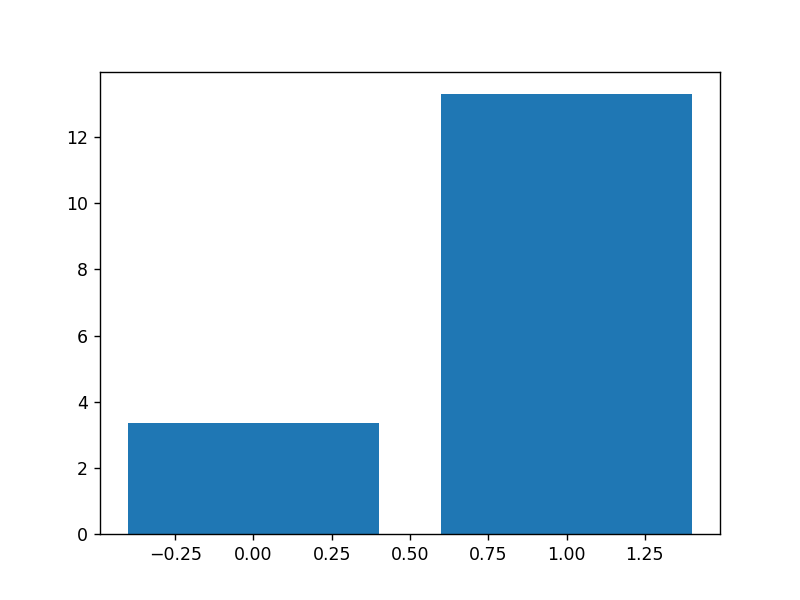

 the percentage of strokes with 1 is 13.303769401330376%.
 the percentage of strokes with 0 is 3.342305966801256%.
the percentage difference is 9.96146343452912%.
---------------------------------------------------------------------------------------------------------
heart_disease


<IPython.core.display.Javascript object>


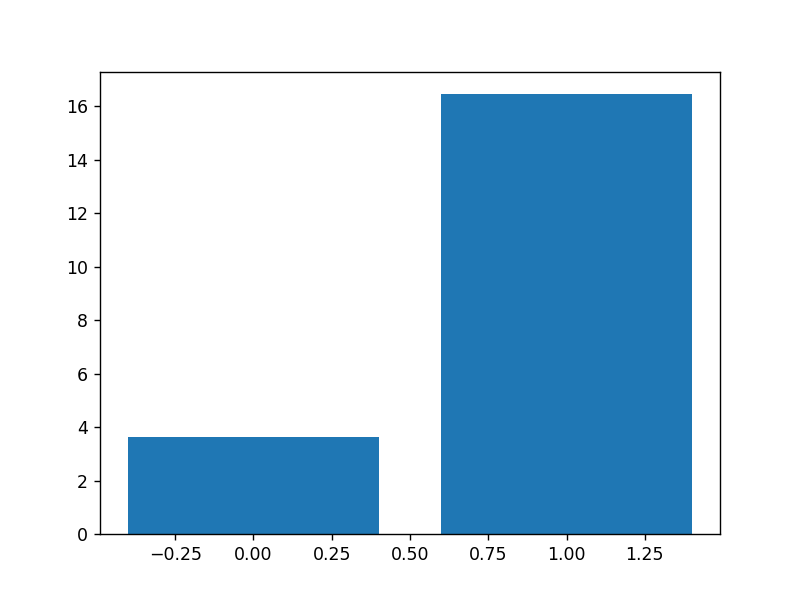

 the percentage of strokes with 1 is 16.46090534979424%.
 the percentage of strokes with 0 is 3.621945992284612%.
the percentage difference is 12.838959357509626%.
---------------------------------------------------------------------------------------------------------
ever_married


<IPython.core.display.Javascript object>


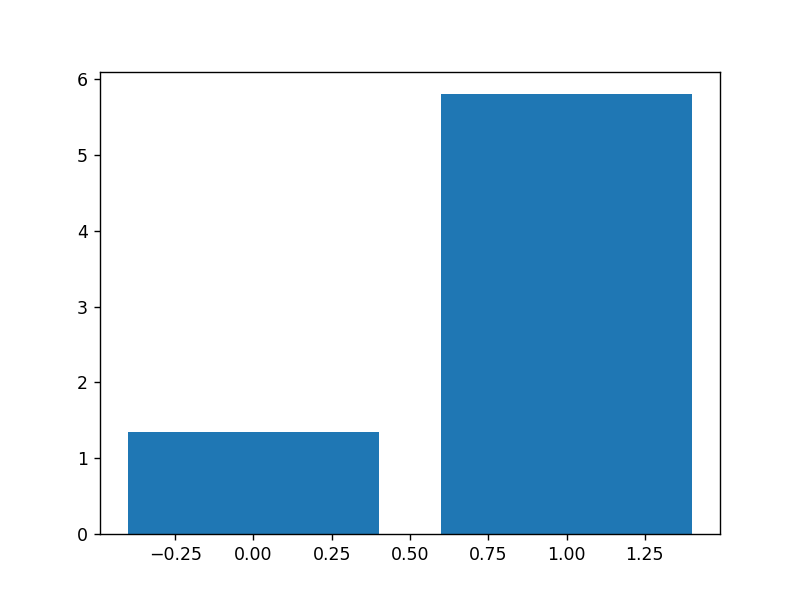

 the percentage of strokes with 1 is 5.805243445692884%.
 the percentage of strokes with 0 is 1.3489736070381233%.
the percentage difference is 4.456269838654761%.
---------------------------------------------------------------------------------------------------------
Residence_type


<IPython.core.display.Javascript object>


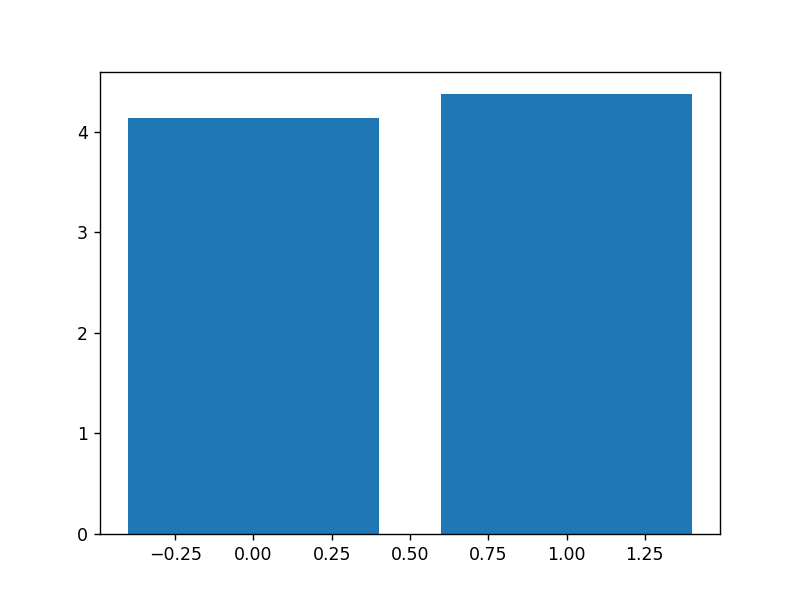

 the percentage of strokes with 1 is 4.377510040160643%.
 the percentage of strokes with 0 is 4.13393964448119%.
the percentage difference is 0.24357039567945282%.
---------------------------------------------------------------------------------------------------------
Male


<IPython.core.display.Javascript object>


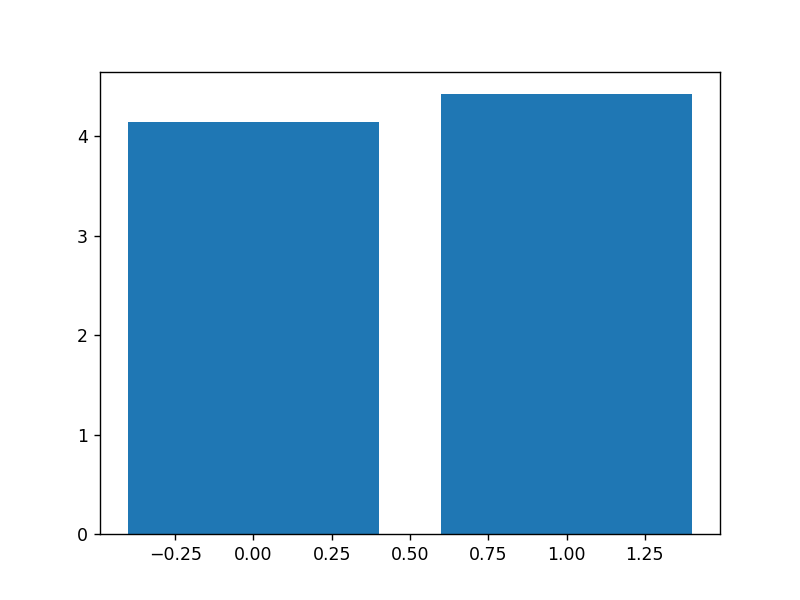

 the percentage of strokes with 1 is 4.4256588761810045%.
 the percentage of strokes with 0 is 4.140786749482402%.
the percentage difference is 0.28487212669860273%.
---------------------------------------------------------------------------------------------------------
Female


<IPython.core.display.Javascript object>


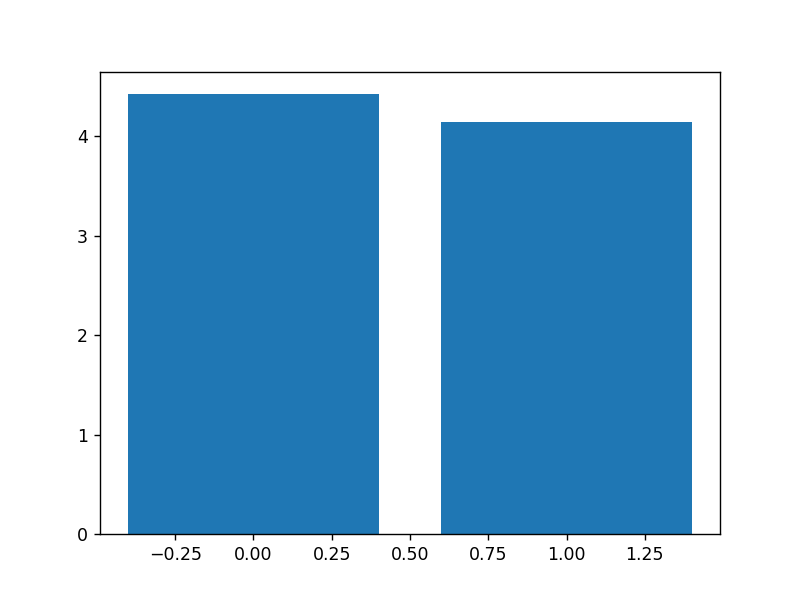

 the percentage of strokes with 1 is 4.142216085605799%.
 the percentage of strokes with 0 is 4.423459244532803%.
the percentage difference is -0.2812431589270039%.
---------------------------------------------------------------------------------------------------------
Govt_job


<IPython.core.display.Javascript object>


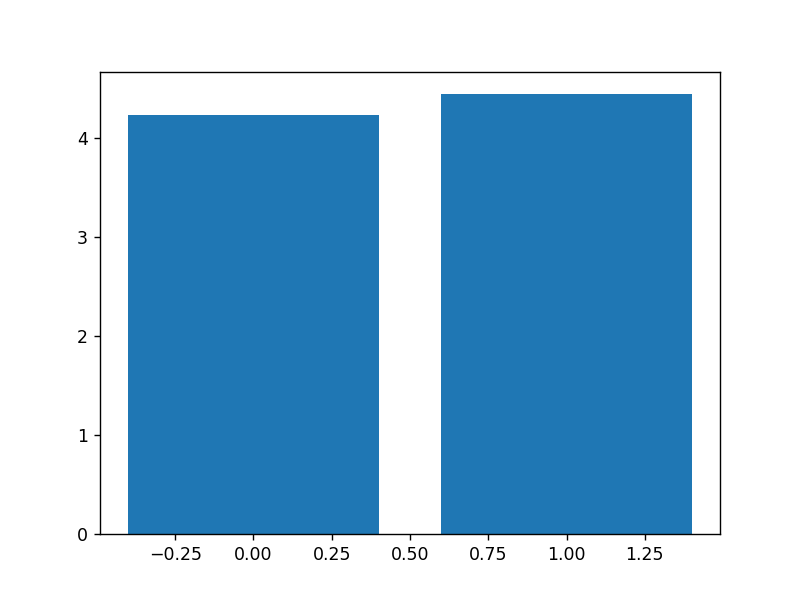

 the percentage of strokes with 1 is 4.444444444444445%.
 the percentage of strokes with 0 is 4.229960271091376%.
the percentage difference is 0.21448417335306846%.
---------------------------------------------------------------------------------------------------------
Private


<IPython.core.display.Javascript object>


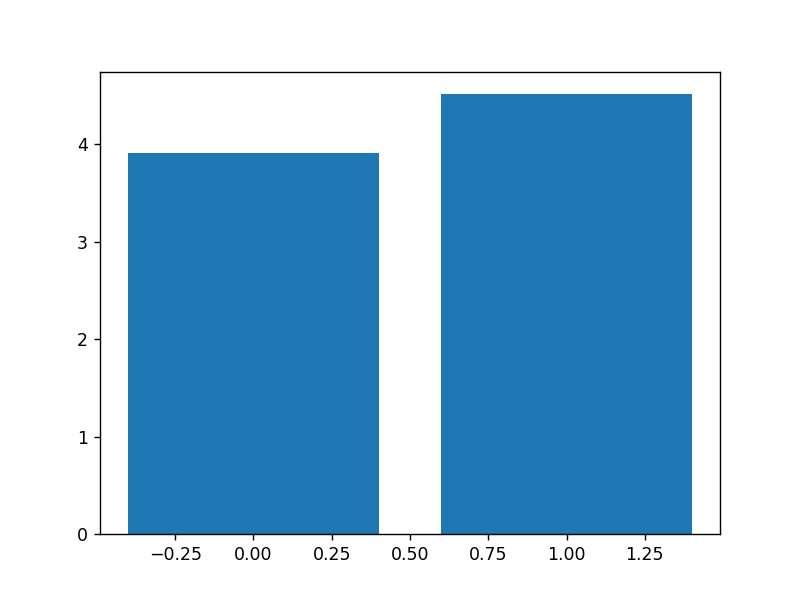

 the percentage of strokes with 1 is 4.517965136961935%.
 the percentage of strokes with 0 is 3.9084842707340326%.
the percentage difference is 0.6094808662279028%.
---------------------------------------------------------------------------------------------------------
children


<IPython.core.display.Javascript object>


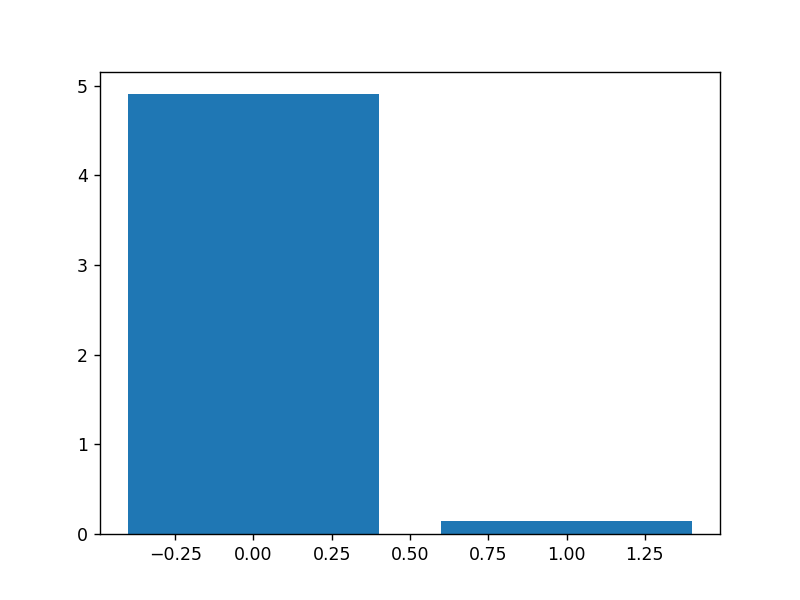

 the percentage of strokes with 1 is 0.14903129657228018%.
 the percentage of strokes with 0 is 4.9079754601226995%.
the percentage difference is -4.758944163550419%.
---------------------------------------------------------------------------------------------------------
Self-employed


<IPython.core.display.Javascript object>


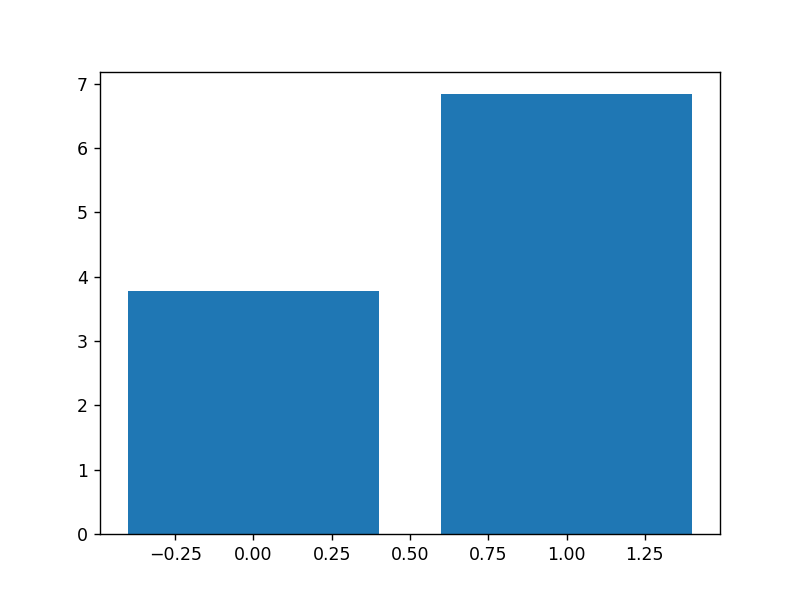

 the percentage of strokes with 1 is 6.838709677419355%.
 the percentage of strokes with 0 is 3.7735849056603774%.
the percentage difference is 3.0651247717589776%.
---------------------------------------------------------------------------------------------------------
Never_worked


<IPython.core.display.Javascript object>


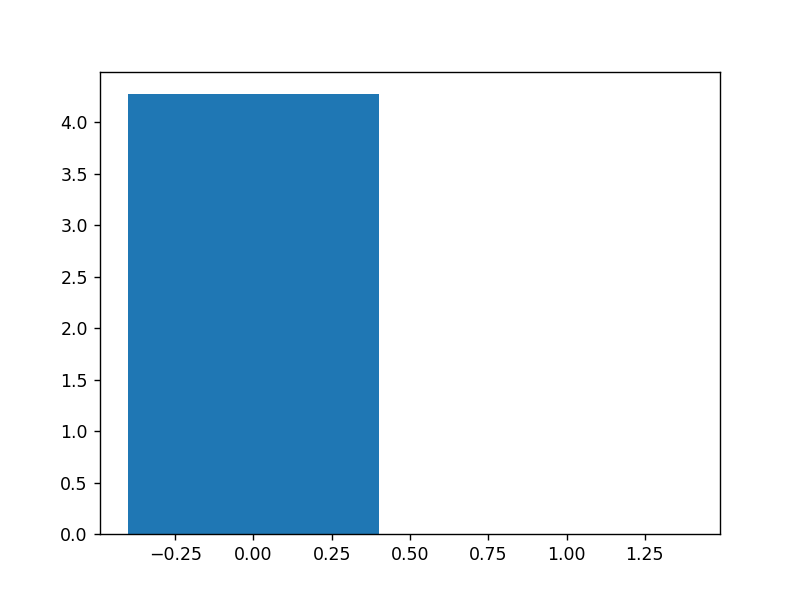

 the percentage of strokes with 1 is 0.0%.
 the percentage of strokes with 0 is 4.276652342950685%.
the percentage difference is -4.276652342950685%.
---------------------------------------------------------------------------------------------------------
['Never_worked', 'children', 'Self-employed', 'Residence_type', 'Male', 'Female', 'Govt_job', 'Private']


In [94]:
# run 2nd stage data preprocessing by coorolation with stroke chance

data = pd.read_csv('data/preprocessed-healthcare-dataset-stroke-data.csv')

# get all keys from datasheet
bols = []
for key in data.columns:
    bols.append(key)

# remove non-bools manually, possible for small data set
bols.remove('age')
bols.remove('avg_glucose_level')
bols.remove('bmi')
bols.remove('stroke')
bols.remove('smoking_status')

# manually set non-bool keys acceptable for small column list
nbols = ['age','avg_glucose_level','bmi']

# innitialse class
preplots = preplotter(data)

remove_list = ['Never_worked', 'children', 'Self-employed']

# look over bool variables
for name in bols:
    print(name)
    # return difference in percentage stroke, if there is coorolation there would be a significant difference in stroke
    # amounts between the boolean anwsers
    dv = preplots.histogram(name)
    print('---------------------------------------------------------------------------------------------------------')
    # remove data that has similar stroke percentage i.e. non-predictive of stroke chances
    if abs(dv) < 1.1 : #ARBITRARY VALUE SET
        remove_list.append(name)

print(remove_list)

# initalize preprocessor class agaon
data_p = Preprocessor(data.copy())
# remove 2nd wave of non-predictive data
for name in remove_list:
    data_p.remove(name)
       
# save to new file
data_p.data.to_csv('data/preprocessed-healthcare-dataset-stroke-data.csv', index=False)


We use the plotter class to check to see if the non-boolean data is correlated.

age


<IPython.core.display.Javascript object>


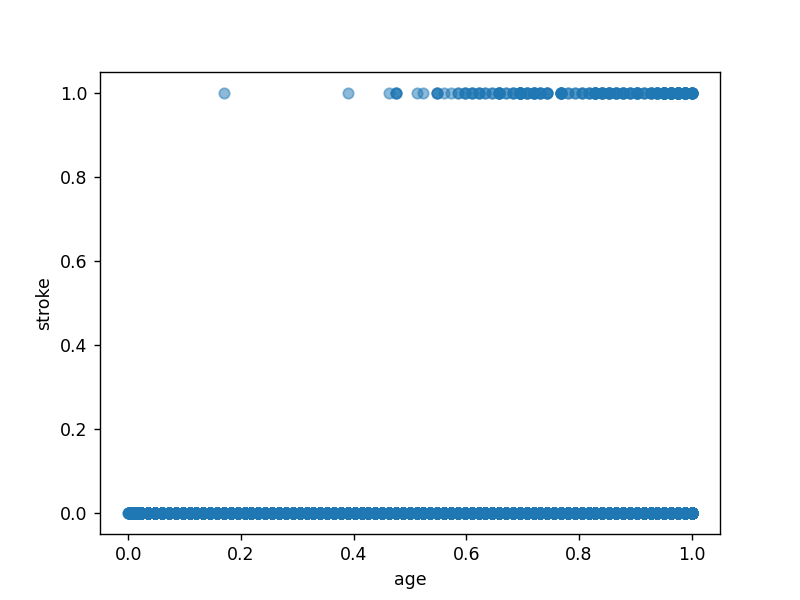

avg_glucose_level


<IPython.core.display.Javascript object>


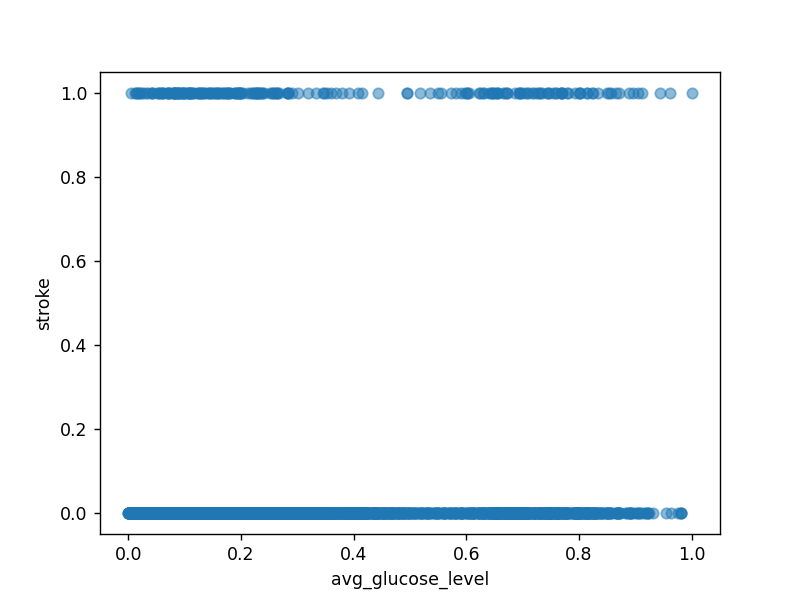

bmi


<IPython.core.display.Javascript object>


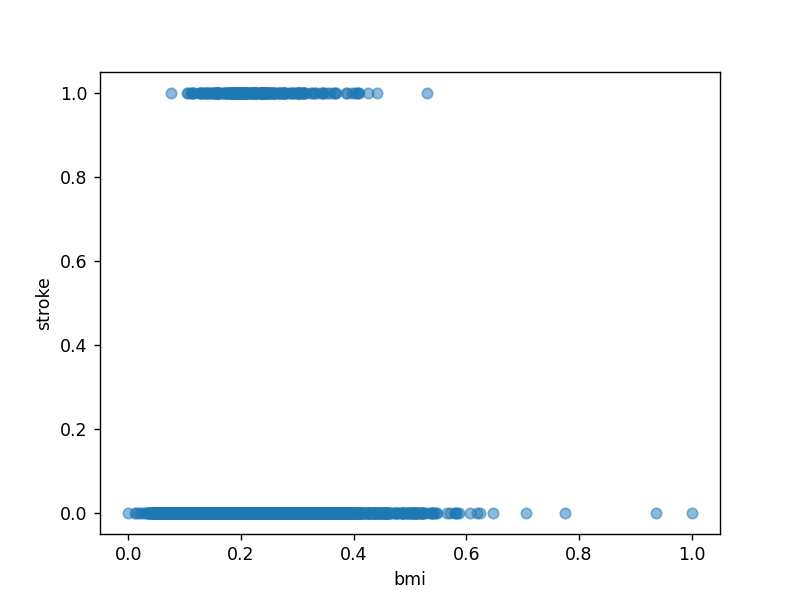

In [95]:
# print scatter graphs for each non-boolean function to check for corrolation
for name in nbols:
    print(name)
    preplots.scatter(name, 'stroke')

<IPython.core.display.Javascript object>


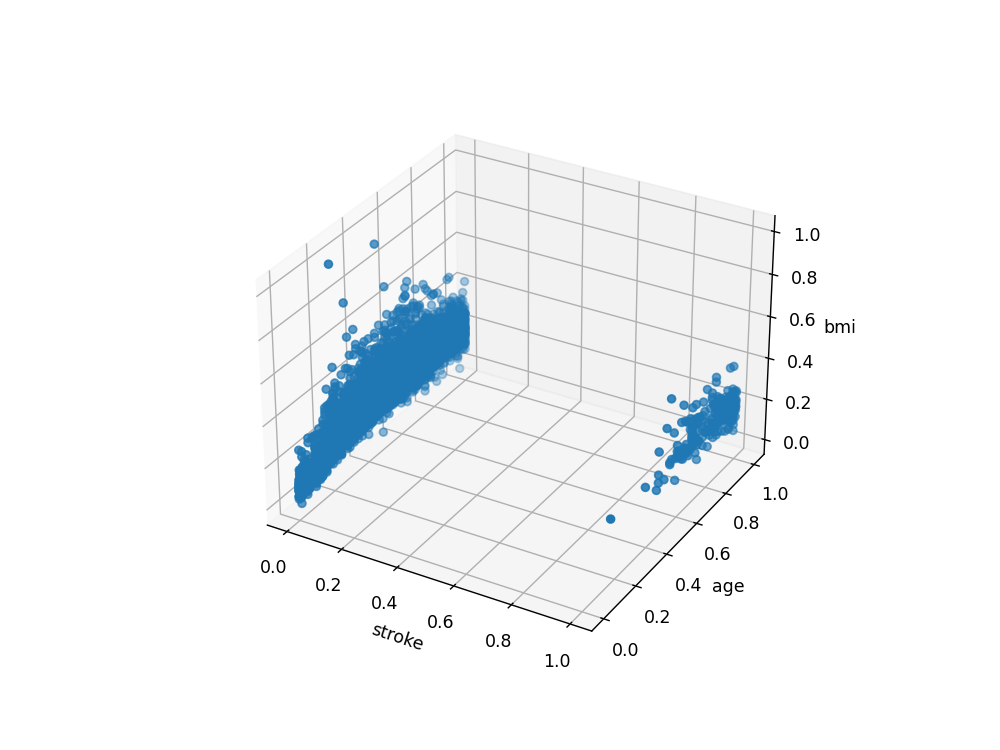

In [96]:
# visualise data in 3D
preplots.scatter('stroke','age','bmi')

# Column removal

Here we removed columns from the preprocessed data, in preperation for the final notebook where the effects will be compared.

In [97]:
# read preprocessed data to delete columns to used in the final cell, hence output to csv

# load preporcessed data
data = pd.read_csv('data/preprocessed-healthcare-dataset-stroke-data.csv')

# run loop over names
for name in data.columns:
    
    # generate class using copy of data so it can be reused in loop
    datap = Preprocessor(data.copy())
    # remove specific data column
    datare = datap.remove(name)
    # output to csv in diff file 
    datare.to_csv(f'data/data_removed/{name}_removed-healthcare-dataset-stroke-data.csv',)
data

age  hypertension  heart_disease  ever_married  avg_glucose_level  \
0     0.816895             0              1             1           0.801265   
1     0.975586             0              1             1           0.234512   
2     0.597168             0              0             1           0.536008   
3     0.963379             1              0             1           0.549349   
4     0.987793             0              0             1           0.605161   
...        ...           ...            ...           ...                ...   
4904  0.157715             0              0             0           0.221402   
4905  0.987793             0              0             1           0.323516   
4906  0.426270             0              0             1           0.128658   
4907  0.621582             0              0             1           0.513203   
4908  0.536133             0              0             1           0.139230   

           bmi  smoking_status  stroke  
0     0.301260               1       1  
1     0.254296               3       1  
2     0.276060               0       1  
3     0.156930               3       1  
4     0.214204               1       1  
...        ...             ...     ...  
4904  0.095074               2       0  
4905  0.340206               3       0  
4906  0.232532               3       0  
4907  0.175258               1       0  
4908  0.182131               2       0  

[4909 rows x 8 columns]

# Implementing the classifier
In this section, we decide which of the classifiers to use and how to split our data 



## The regressor class
This class is initialised with any sci kit learn regressor/classifier object, any sci kit cross validation object and a csv file with the data. It fits the regressor with data split using the cross validator and stores the resulting y_pred, X_test and y_test values. 



In [98]:
def load(fname: str, cv: str) -> tuple:
    """Loads data from a CSV file and splits it using scikit"""

    # read data
    data = pd.read_csv(fname)
    y_column = 'stroke'
    X_columns = list(data.columns)
    X_columns.remove(y_column)
    X = data[X_columns].to_numpy()
    y = data[y_column].to_numpy()

    # splitting calling the scikit split method of each cross validator
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    # return all
    return X, y, X_train, y_train, X_test, y_test

class Regressor:
    """Container for analysing different metrics for a single regression class"""
    def __init__(self, cls, fname: str, cv, cls_kwargs: dict = {}, cv_kwargs: dict = {} ):
        # construct regressor object
        self.regressor = cls(**cls_kwargs)
        self.cv = cv(**cv_kwargs)

        # use load function
        # where cv is a splitting class i.e kFold()
        self.X, self.y, self.X_train, self.y_train, self.X_test, self.y_test = load(fname, self.cv)

        # fit data
        self.regressor.fit(self.X_train, self.y_train)

        # get predicted data
        self.y_pred = self.regressor.predict(self.X_test)

    def metric(self, cls, **kwargs) -> float:
        """Takes a sklearn.metrics class and returns the score of the regressor object"""

        # use the metric class to get a score
        return cls(self.y_test, self.y_pred)
    
        # method that predicts new y values from new x data
    def predict(self, newdata):
        y = self.regressor.predict(newdata)
        return y

## The Postplotter class
This class has the plots we want to make after regressing the data, currently it has just the confusion matrix.

In [99]:
class postplotter:
    
    # initalise self with regressor object and test data
    def __init__ (self, x_test, y_test, y_pred):
        """Initalise postplotter class with x test, y test and y prediction data."""
        
        self.y_test = y_test
        self.y_pred = y_pred
        self.x_test = x_test
        
    # plots confusion matrix and gives FR values
        
    def confmatrix (self, title: str):
        """Plots a confusion matrix using the data and gives percision, recall and F1 score, 
        takes title of plot as argument."""
        
        # generate plots and axis for binary data confusion matrix
        
        fig, ax = plt.subplots()
        array = np.zeros((2, 2))

        for i, correct_value in enumerate(self.y_test):
            predicted_value = int(abs(np.round(self.y_pred[i])))
            array[predicted_value, correct_value] += 1
        
        # print dataframe represenation of array
        print(pd.DataFrame(array),"\n")

        # plot array as image
        im = ax.imshow(array, origin='lower', cmap='viridis')

        # label axes
        ax.set_xlabel('Real Type')
        ax.set_ylabel('Predicted Type')

        # add colorbar
        plt.colorbar(im)
        
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        for i in range(2):
            for j in range(2):

                # leave colour as white as the default
                color = 'black'
                if (i == 2 and j != 2):

                    # when overdose happened but wasn't predicted, changed colour
                    # to red if it is not 0
                    if array[i, j] == 0:
                        color = 'black'

                    else:
                        color = 'black'

                # set colour to black for the light coloured square
                # this is done after plotting once
                elif i == 1 and j == 1:
                    color = 'black'

                # add text with correct colour
                ax.text(j, i, array[i, j], ha='center', va='center', color=color)
        
        # sets axis title
        ax.set_title(title, fontsize=15)

        
        # calculates F1, P and R values
        R = (array[1,1]/(array[1,1]+array[1,0]))*100
        
        if (array[1,1]+array[0,1]) != 0:
            P = (array[1,1]/(array[1,1]+array[0,1]))*100
            F1 = 2*P*R/(P+R)
            print(f'Precision: {P:2f}%')
            print(f'Recall R: {R:2f}%\n')
            print(f'F-score F1: {F1:2f}%')
        else:
            P = print('P Could not be calculated')
            F1 = print('F1 Could not be calculated')




## Accuracy issue 
When using the regressor on the entire data sets, classifiers found the best fit to predict 100% of the data to not have a stroke. The way we resolved this issue is by making the regressor run on a sample of the data where we use all the data on strokes and an equal amount of data for non strokes. This is justified below as we checked how this method performed across all the non-stroke data in 22 intervals of 210.

Iteration: 1


<IPython.core.display.Javascript object>


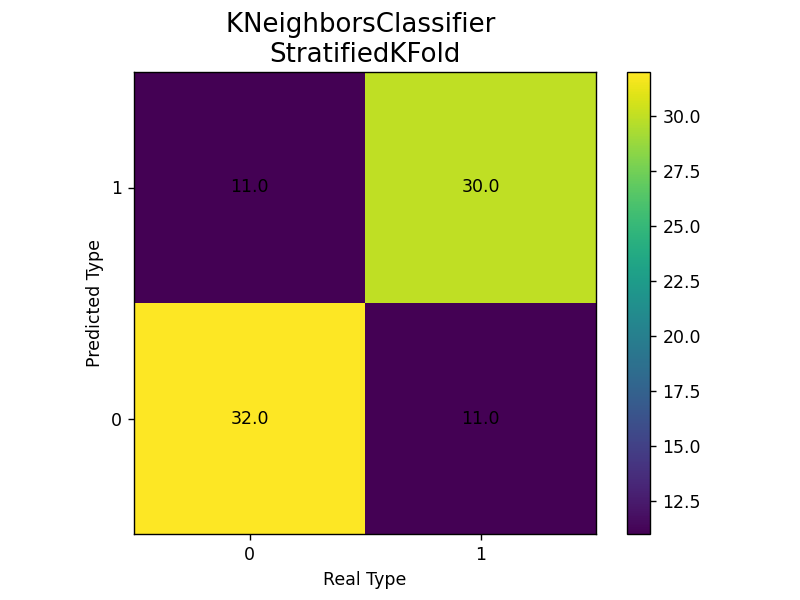

      0     1
0  32.0  11.0
1  11.0  30.0 

Precision: 73.170732%
Recall R: 73.170732%

F-score F1: 73.170732%
Regressor R^2 Score: 0.7380952380952381

-----------------------------------------------------------

Iteration: 2


<IPython.core.display.Javascript object>


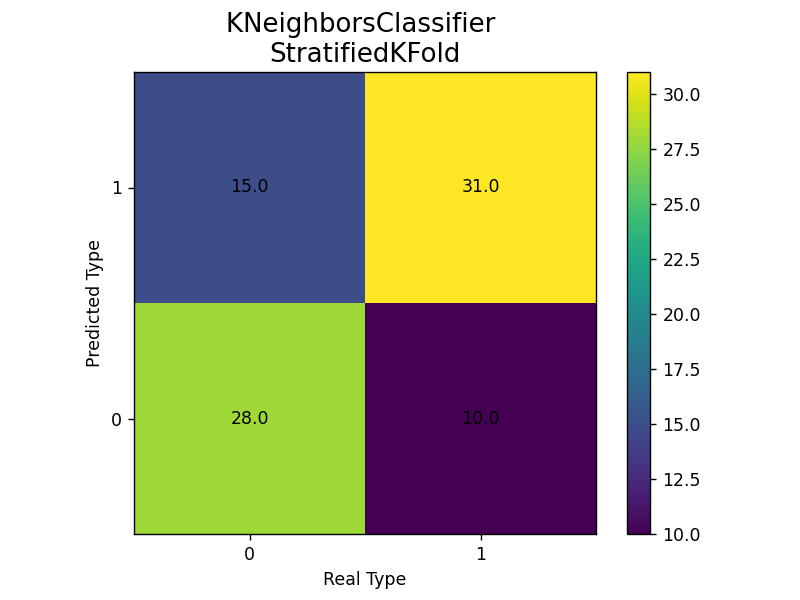

      0     1
0  28.0  10.0
1  15.0  31.0 

Precision: 75.609756%
Recall R: 67.391304%

F-score F1: 71.264368%
Regressor R^2 Score: 0.7023809523809523

-----------------------------------------------------------

Iteration: 3


<IPython.core.display.Javascript object>


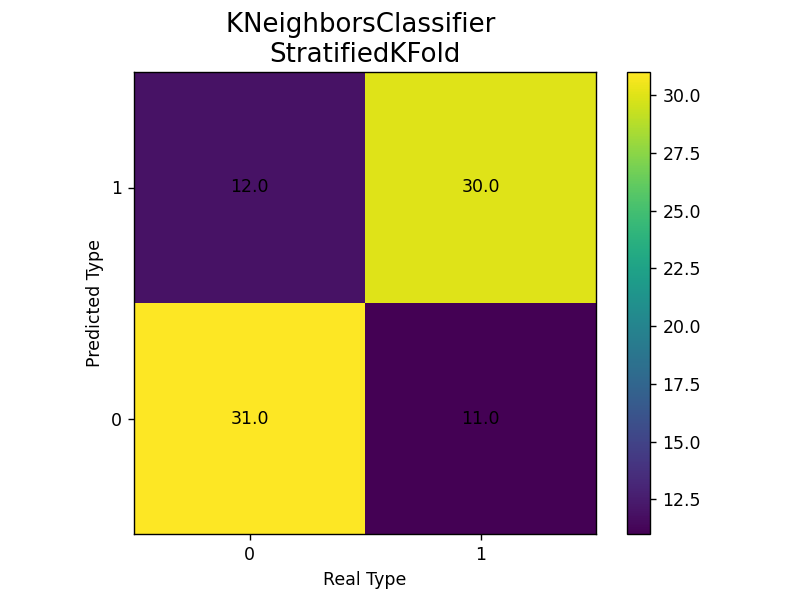

      0     1
0  31.0  11.0
1  12.0  30.0 

Precision: 73.170732%
Recall R: 71.428571%

F-score F1: 72.289157%
Regressor R^2 Score: 0.7261904761904762

-----------------------------------------------------------

Iteration: 4


<IPython.core.display.Javascript object>


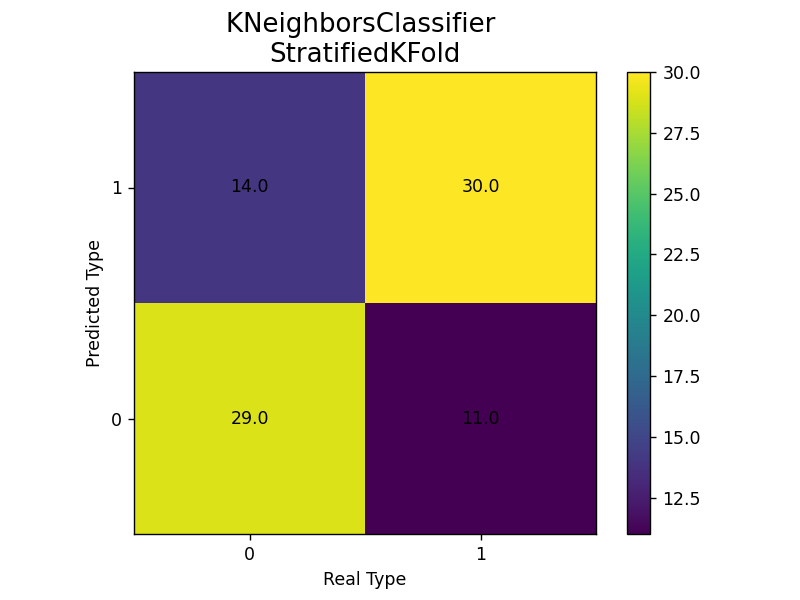

      0     1
0  29.0  11.0
1  14.0  30.0 

Precision: 73.170732%
Recall R: 68.181818%

F-score F1: 70.588235%
Regressor R^2 Score: 0.7023809523809523

-----------------------------------------------------------

Iteration: 5


<IPython.core.display.Javascript object>


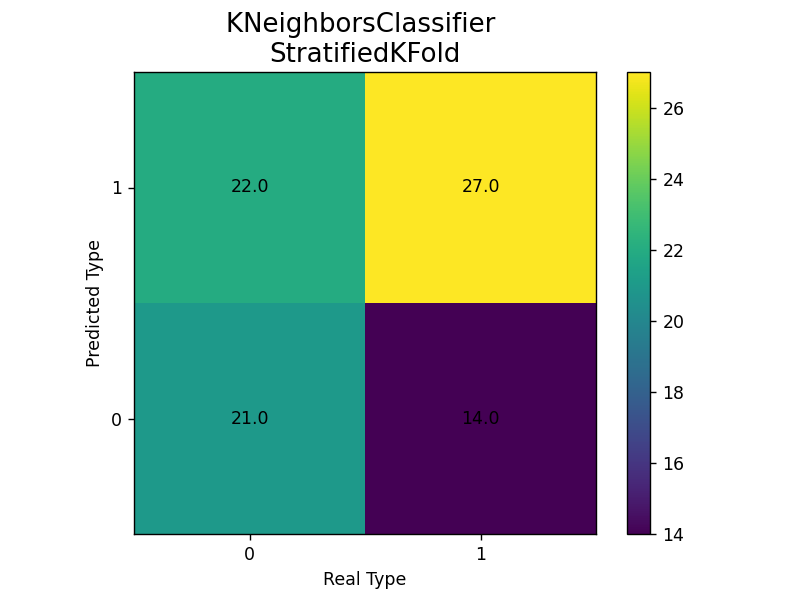

      0     1
0  21.0  14.0
1  22.0  27.0 

Precision: 65.853659%
Recall R: 55.102041%

F-score F1: 60.000000%
Regressor R^2 Score: 0.5714285714285714

-----------------------------------------------------------

Iteration: 6


<IPython.core.display.Javascript object>


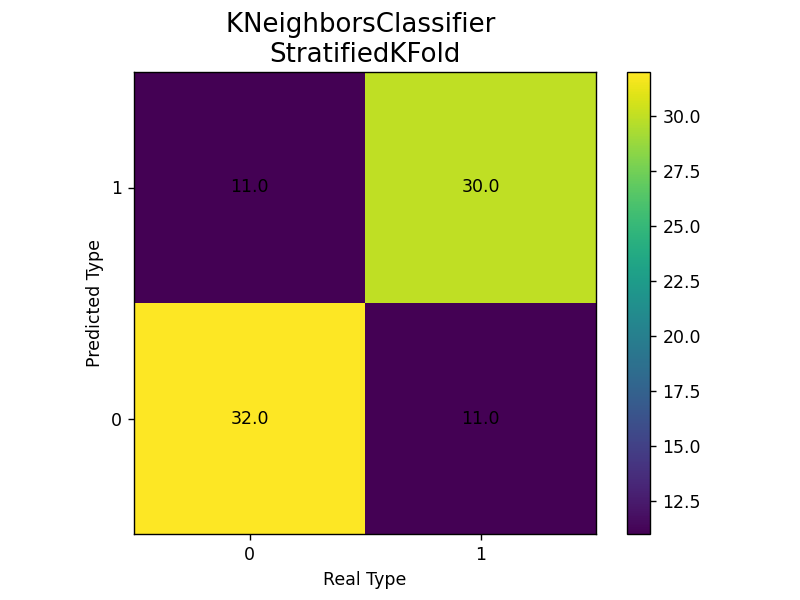

      0     1
0  32.0  11.0
1  11.0  30.0 

Precision: 73.170732%
Recall R: 73.170732%

F-score F1: 73.170732%
Regressor R^2 Score: 0.7380952380952381

-----------------------------------------------------------

Iteration: 7


<IPython.core.display.Javascript object>


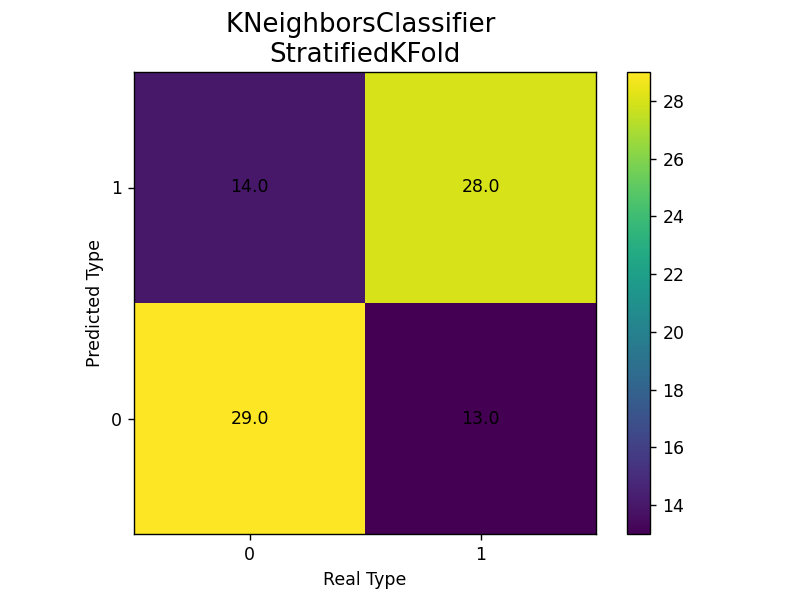

      0     1
0  29.0  13.0
1  14.0  28.0 

Precision: 68.292683%
Recall R: 66.666667%

F-score F1: 67.469880%
Regressor R^2 Score: 0.6785714285714286

-----------------------------------------------------------

Iteration: 8


<IPython.core.display.Javascript object>


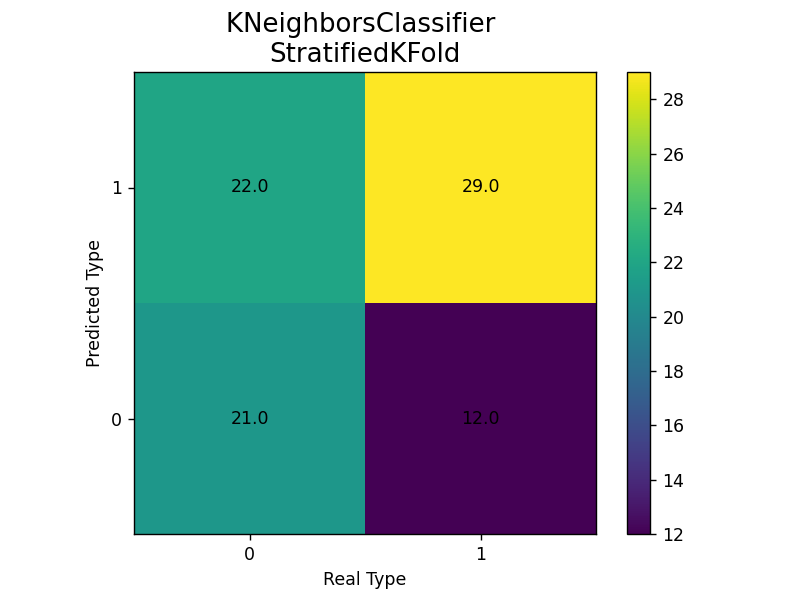

      0     1
0  21.0  12.0
1  22.0  29.0 

Precision: 70.731707%
Recall R: 56.862745%

F-score F1: 63.043478%
Regressor R^2 Score: 0.5952380952380952

-----------------------------------------------------------

Iteration: 9


<IPython.core.display.Javascript object>


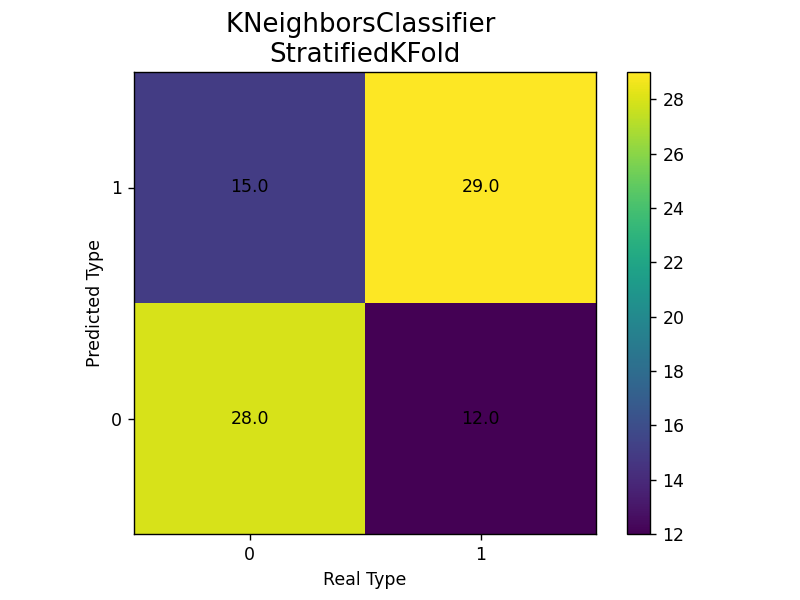

      0     1
0  28.0  12.0
1  15.0  29.0 

Precision: 70.731707%
Recall R: 65.909091%

F-score F1: 68.235294%
Regressor R^2 Score: 0.6785714285714286

-----------------------------------------------------------

Iteration: 10


<IPython.core.display.Javascript object>


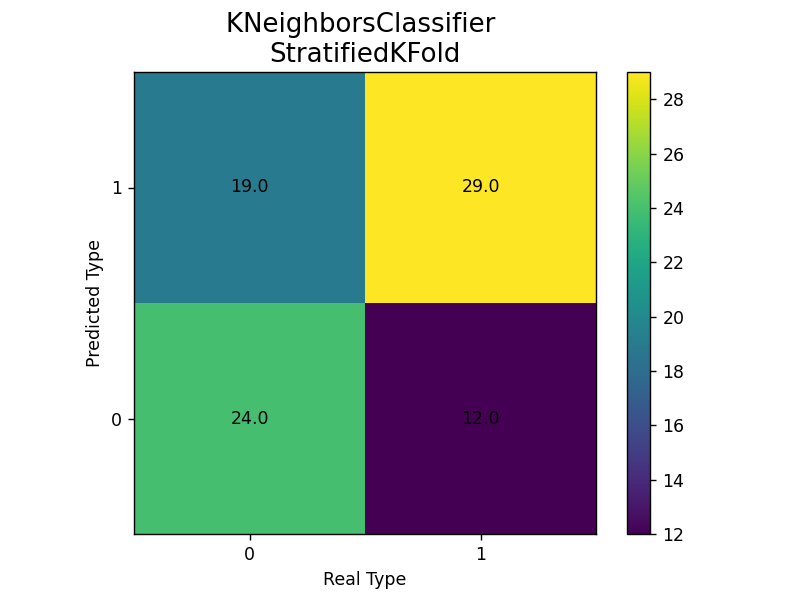

      0     1
0  24.0  12.0
1  19.0  29.0 

Precision: 70.731707%
Recall R: 60.416667%

F-score F1: 65.168539%
Regressor R^2 Score: 0.6309523809523809

-----------------------------------------------------------

Iteration: 11


<IPython.core.display.Javascript object>


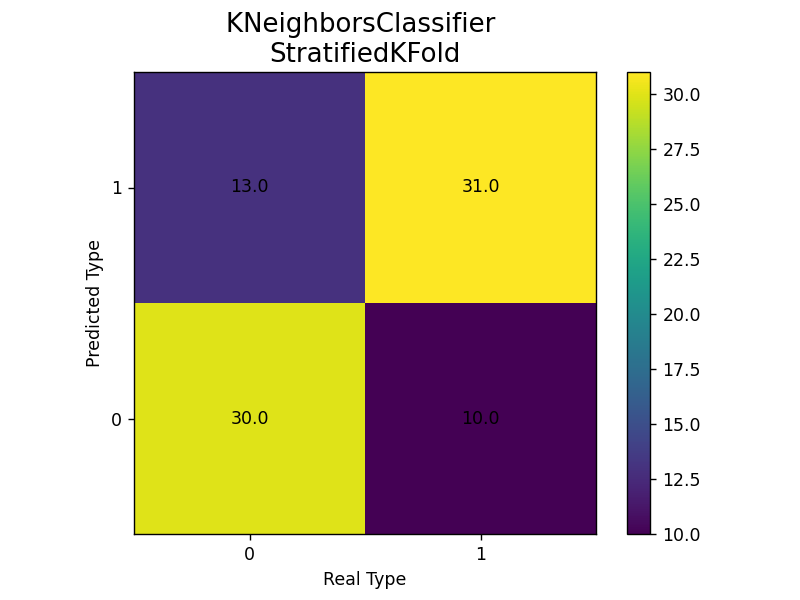

      0     1
0  30.0  10.0
1  13.0  31.0 

Precision: 75.609756%
Recall R: 70.454545%

F-score F1: 72.941176%
Regressor R^2 Score: 0.7261904761904762

-----------------------------------------------------------

Iteration: 12


<IPython.core.display.Javascript object>


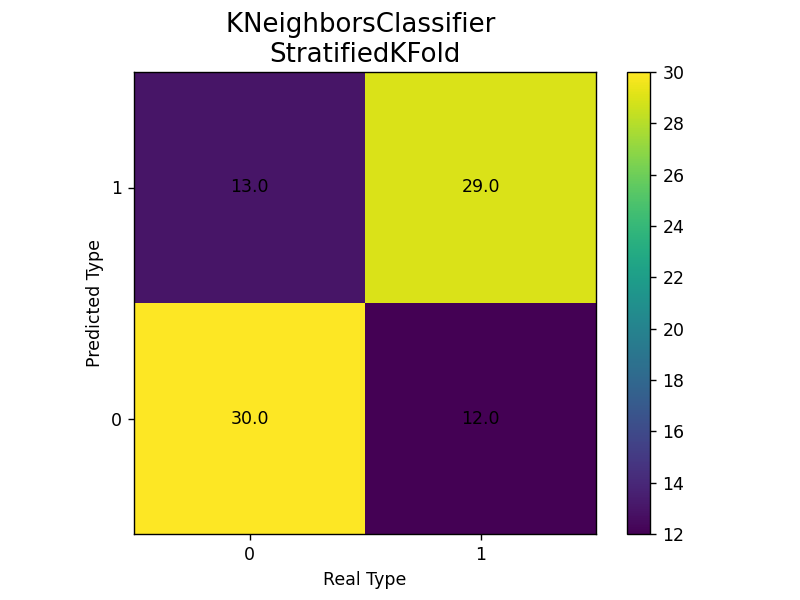

      0     1
0  30.0  12.0
1  13.0  29.0 

Precision: 70.731707%
Recall R: 69.047619%

F-score F1: 69.879518%
Regressor R^2 Score: 0.7023809523809523

-----------------------------------------------------------

Iteration: 13


<IPython.core.display.Javascript object>


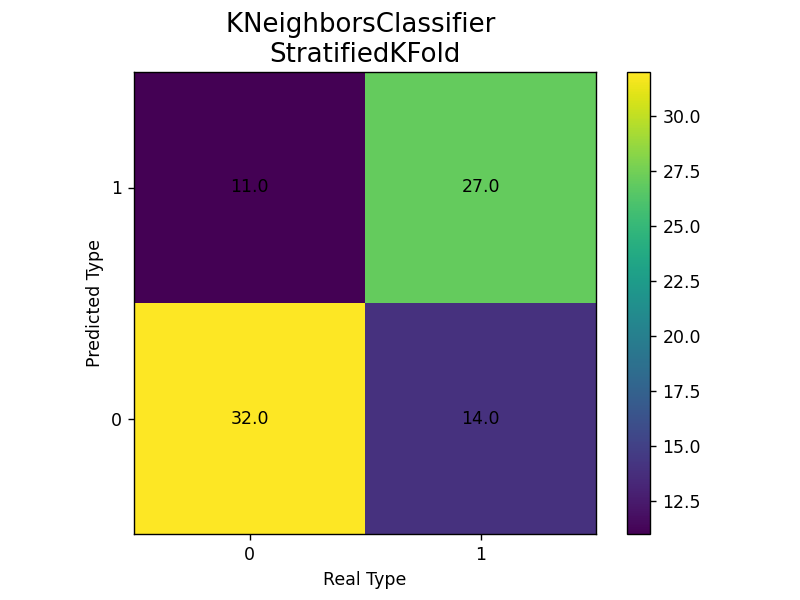

      0     1
0  32.0  14.0
1  11.0  27.0 

Precision: 65.853659%
Recall R: 71.052632%

F-score F1: 68.354430%
Regressor R^2 Score: 0.7023809523809523

-----------------------------------------------------------

Iteration: 14


<IPython.core.display.Javascript object>


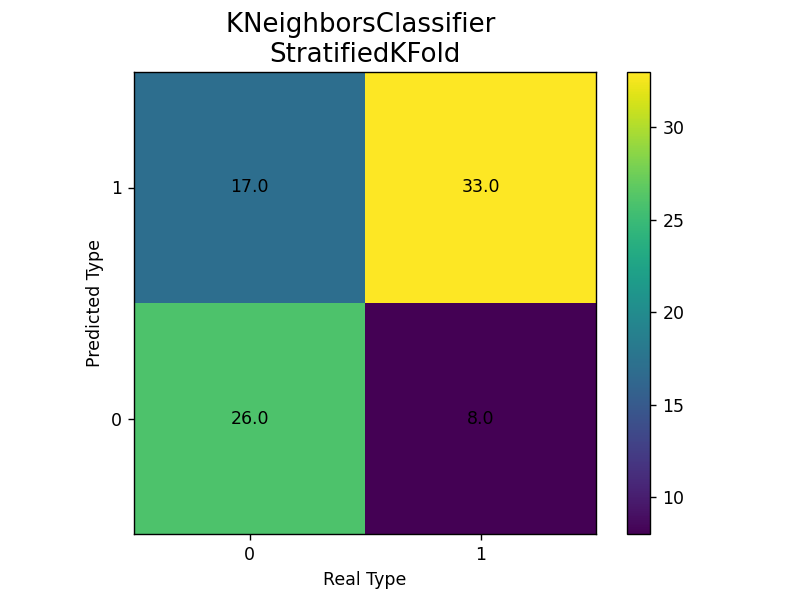

      0     1
0  26.0   8.0
1  17.0  33.0 

Precision: 80.487805%
Recall R: 66.000000%

F-score F1: 72.527473%
Regressor R^2 Score: 0.7023809523809523

-----------------------------------------------------------

Iteration: 15


<IPython.core.display.Javascript object>


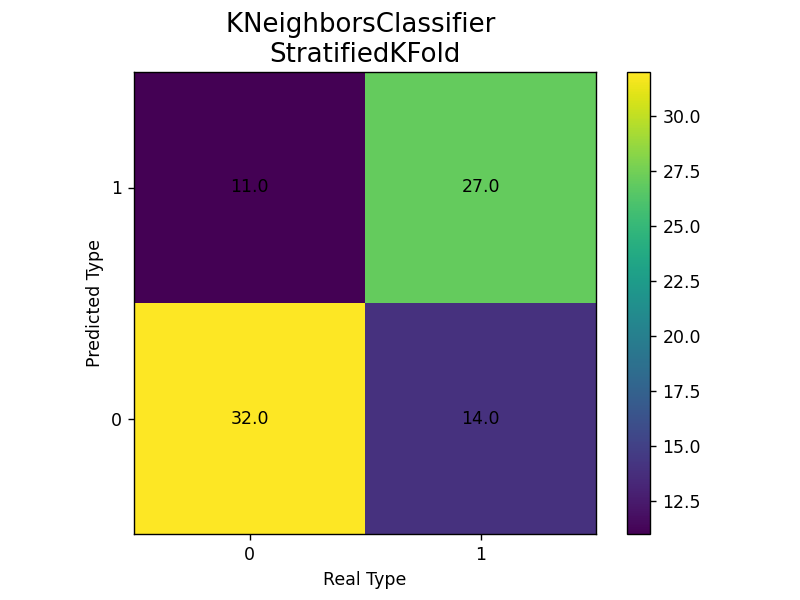

      0     1
0  32.0  14.0
1  11.0  27.0 

Precision: 65.853659%
Recall R: 71.052632%

F-score F1: 68.354430%
Regressor R^2 Score: 0.7023809523809523

-----------------------------------------------------------

Iteration: 16


<IPython.core.display.Javascript object>


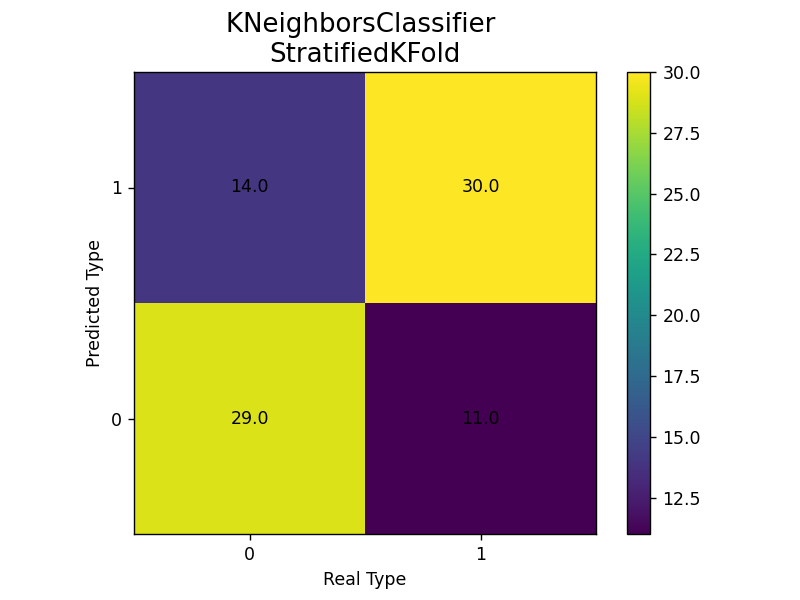

      0     1
0  29.0  11.0
1  14.0  30.0 

Precision: 73.170732%
Recall R: 68.181818%

F-score F1: 70.588235%
Regressor R^2 Score: 0.7023809523809523

-----------------------------------------------------------

Iteration: 17


<IPython.core.display.Javascript object>


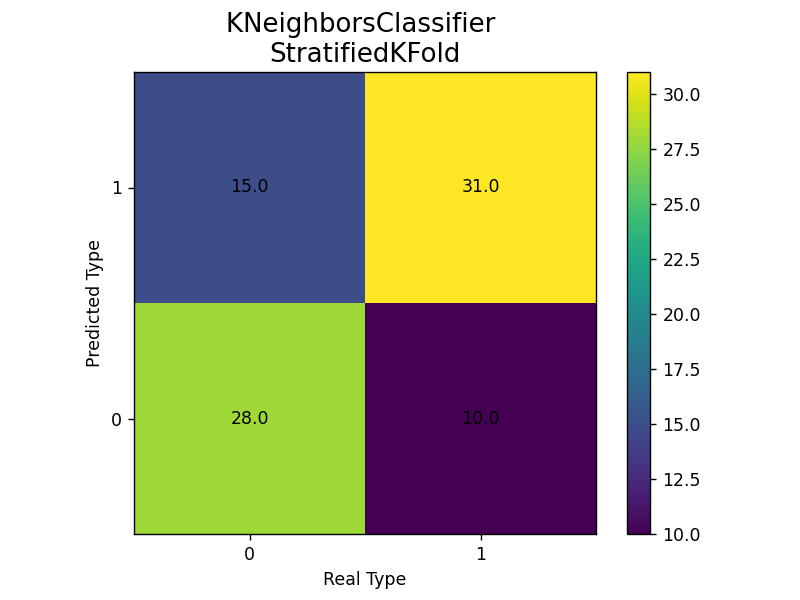

      0     1
0  28.0  10.0
1  15.0  31.0 

Precision: 75.609756%
Recall R: 67.391304%

F-score F1: 71.264368%
Regressor R^2 Score: 0.7023809523809523

-----------------------------------------------------------

Iteration: 18


<IPython.core.display.Javascript object>


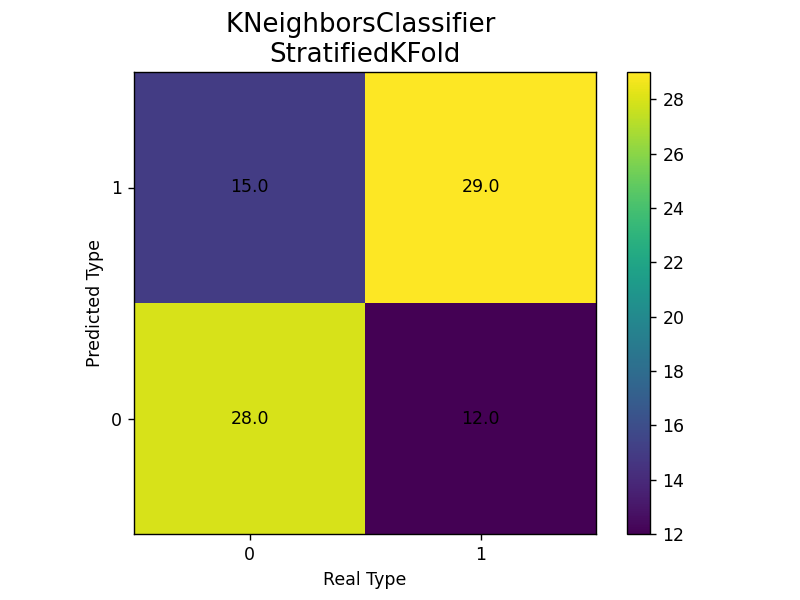

      0     1
0  28.0  12.0
1  15.0  29.0 

Precision: 70.731707%
Recall R: 65.909091%

F-score F1: 68.235294%
Regressor R^2 Score: 0.6785714285714286

-----------------------------------------------------------

Iteration: 19


<IPython.core.display.Javascript object>


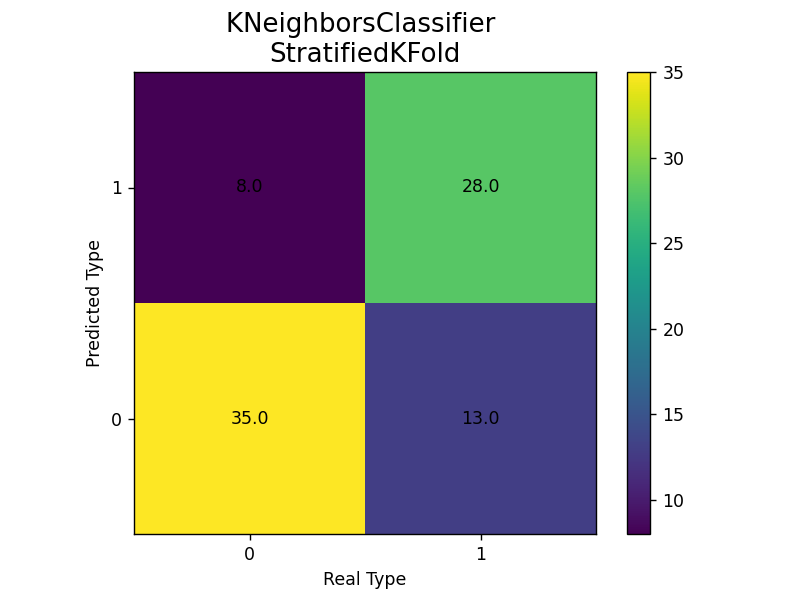

      0     1
0  35.0  13.0
1   8.0  28.0 

Precision: 68.292683%
Recall R: 77.777778%

F-score F1: 72.727273%
Regressor R^2 Score: 0.75

-----------------------------------------------------------

Iteration: 20


<IPython.core.display.Javascript object>


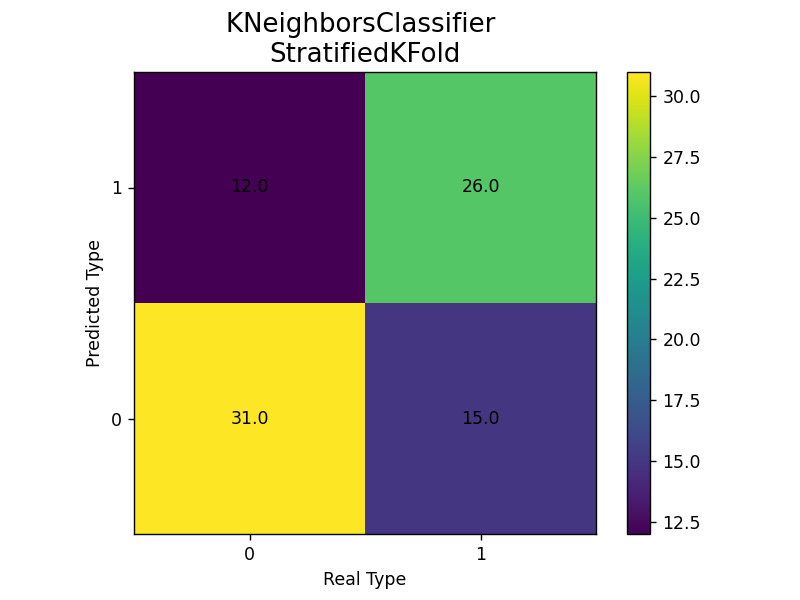

      0     1
0  31.0  15.0
1  12.0  26.0 

Precision: 63.414634%
Recall R: 68.421053%

F-score F1: 65.822785%
Regressor R^2 Score: 0.6785714285714286

-----------------------------------------------------------

Iteration: 21


<IPython.core.display.Javascript object>


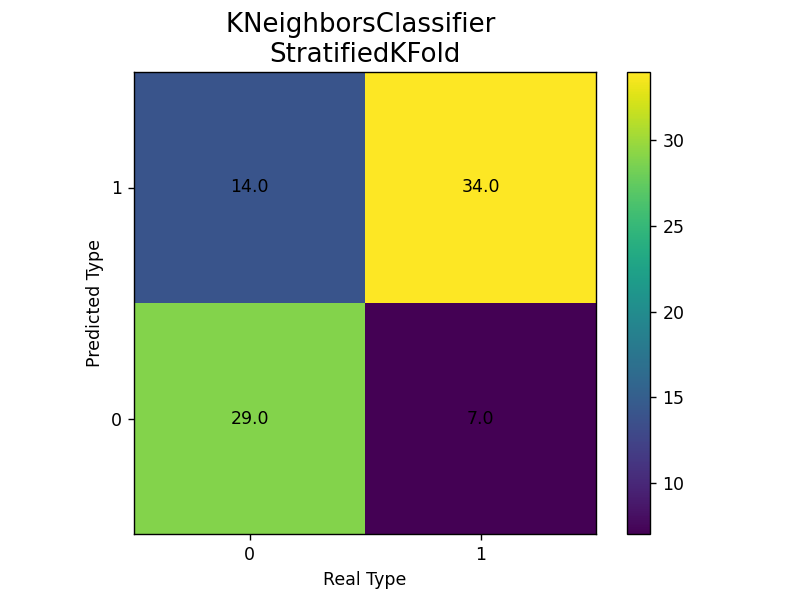

      0     1
0  29.0   7.0
1  14.0  34.0 

Precision: 82.926829%
Recall R: 70.833333%

F-score F1: 76.404494%
Regressor R^2 Score: 0.75

-----------------------------------------------------------



In [100]:
#trying the KNeighbours classifier to justify using small amounts of the data to train the classifier 
daata = pd.read_csv('data/preprocessed2-healthcare-dataset-stroke-data.csv')

strdata = daata.iloc[:210, :] #210 rows of stroke data

for n in range(1,22): #22 lots of 210 in non-stroke data
    
    rnddata = daata.iloc[210+n*210:210+(n+1)*210,:]
    concat = strdata.append(rnddata)  
    concat.to_csv(f'data/splits/split{n}.csv', index = False)
    
    rg = Regressor(KNeighborsClassifier, f'data/splits/split{n}.csv', StratifiedKFold)
    a = postplotter(rg.X_test, rg.y_test, rg.y_pred)
    
    print(f'Iteration: {n}')
    a.confmatrix('{}'.format(type(rg.regressor).__name__)+' \n{}'.format(type(rg.cv).__name__ ) )
    print(f'Regressor R^2 Score: {rg.regressor.score(rg.X_test, rg.y_test)}\n\n-----------------------------------------------------------\n')

## Which classifier and which splitting method to use?
In this cell we looped our regressor class over different CV and regression objects from scikit learn and compared the best F-scores to determine which we would use for our data. 

In the end we decided it is best to use stratified Kfold so an even amount of the stroke data and non stroke data is used to fit the model. 

Once we decided to use these, the predicitivity was further analysed in notebook 2

In [101]:
#borrowed from the scikit learn documentation to visualise the different splitting techniques

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

[<class 'sklearn.linear_model._logistic.LogisticRegression'>, <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, <class 'sklearn.ensemble._forest.RandomForestRegressor'>]


<IPython.core.display.Javascript object>


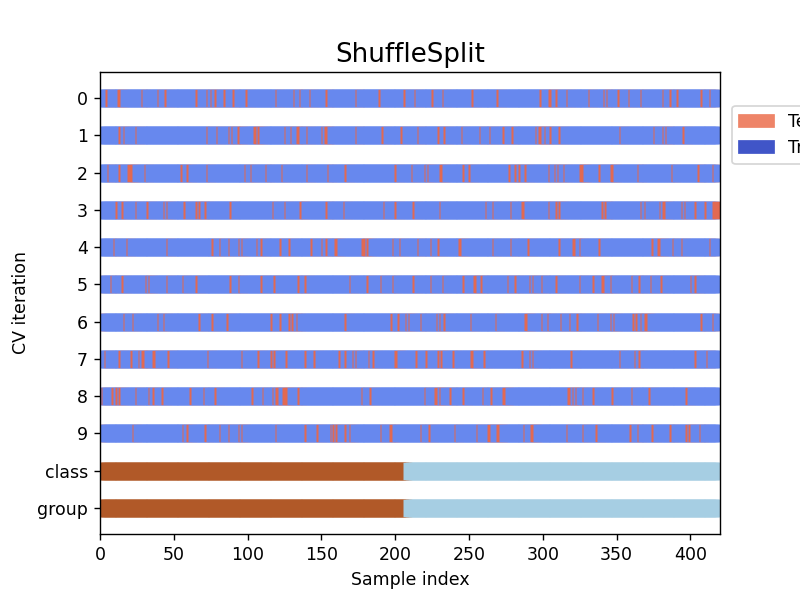

<IPython.core.display.Javascript object>


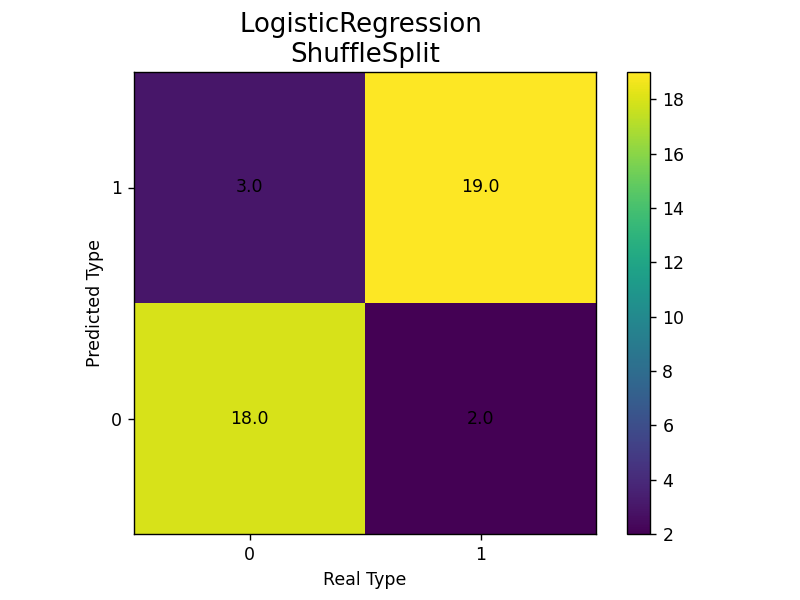

      0     1
0  18.0   2.0
1   3.0  19.0 

Precision: 90.476190%
Recall R: 86.363636%

F-score F1: 88.372093%


<IPython.core.display.Javascript object>


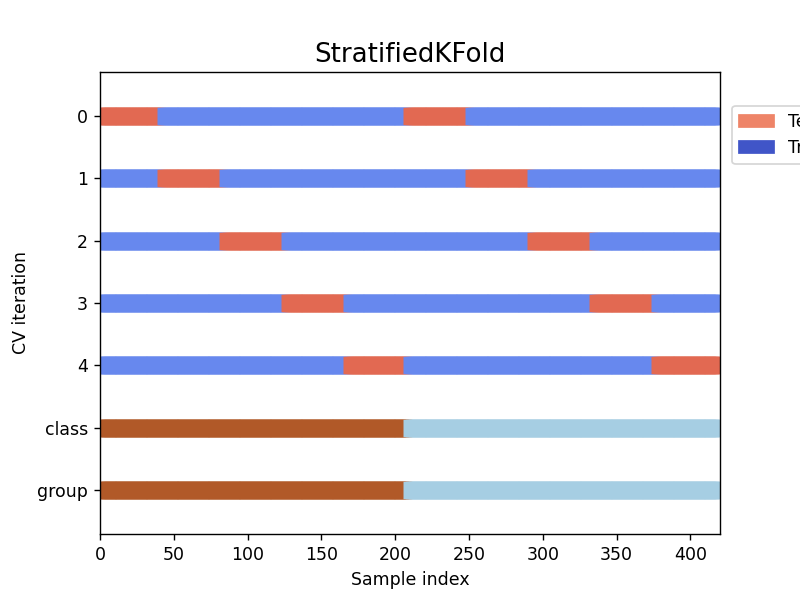

<IPython.core.display.Javascript object>


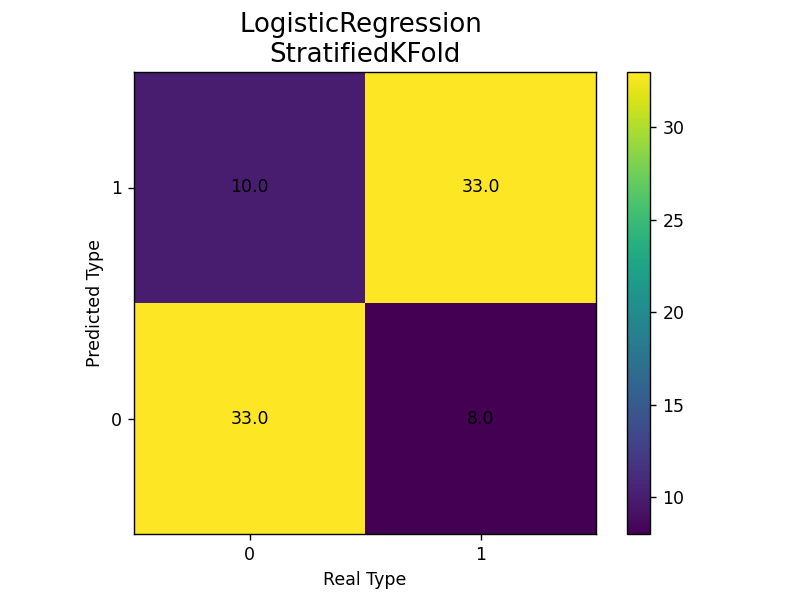

      0     1
0  33.0   8.0
1  10.0  33.0 

Precision: 80.487805%
Recall R: 76.744186%

F-score F1: 78.571429%


<IPython.core.display.Javascript object>


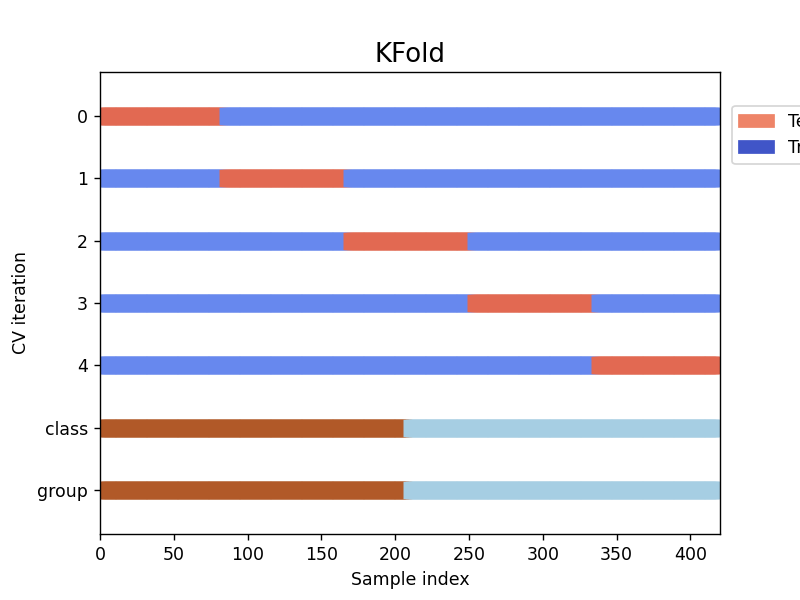

<IPython.core.display.Javascript object>


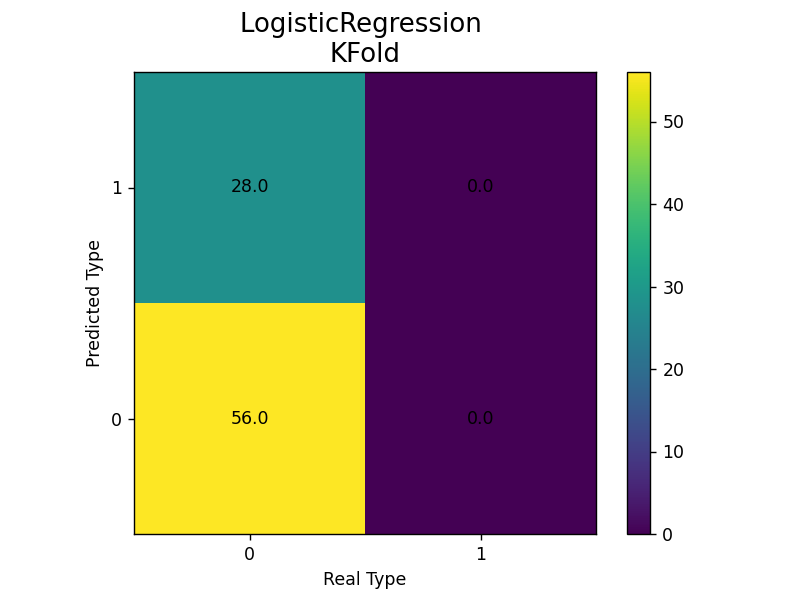

      0    1
0  56.0  0.0
1  28.0  0.0 

P Could not be calculated
F1 Could not be calculated


<IPython.core.display.Javascript object>


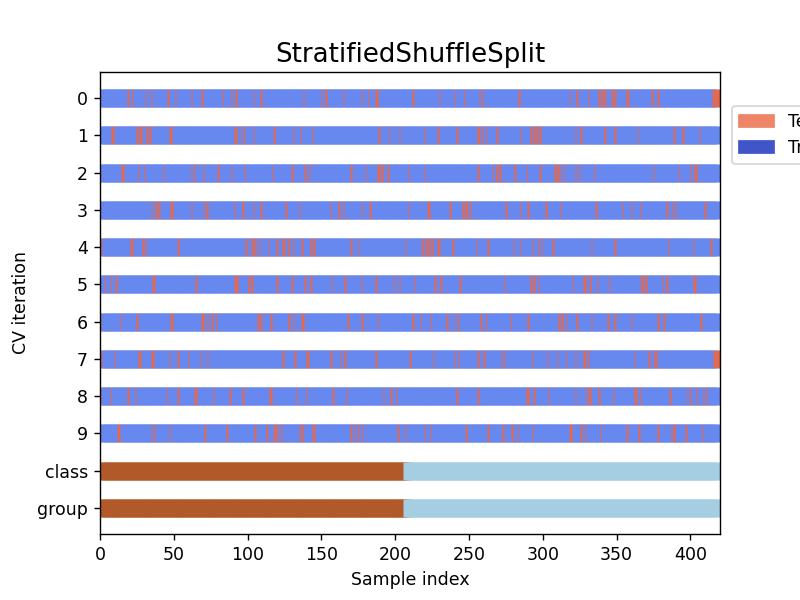

<IPython.core.display.Javascript object>


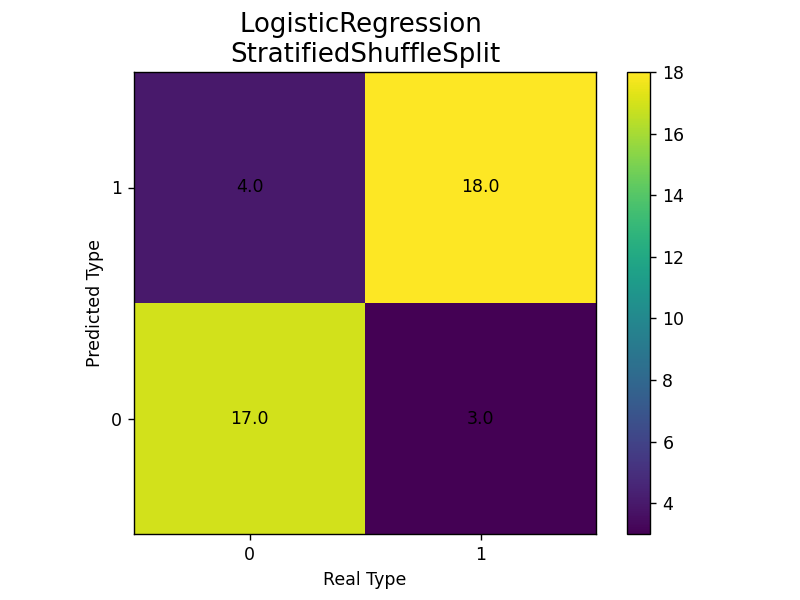

      0     1
0  17.0   3.0
1   4.0  18.0 

Precision: 85.714286%
Recall R: 81.818182%

F-score F1: 83.720930%


<IPython.core.display.Javascript object>


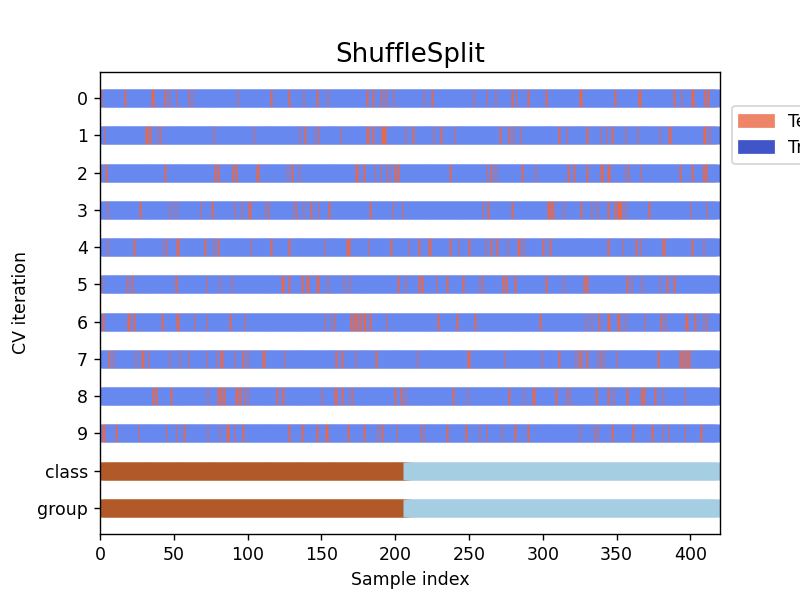

<IPython.core.display.Javascript object>


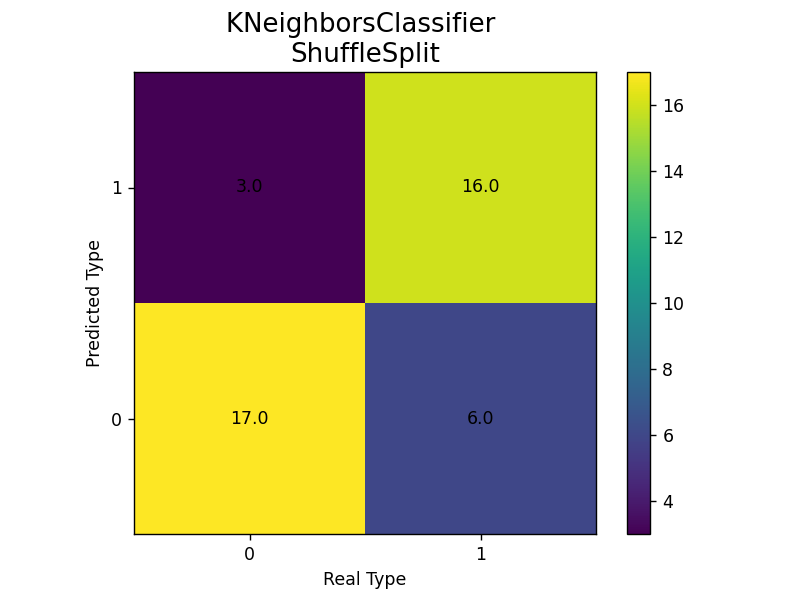

      0     1
0  17.0   6.0
1   3.0  16.0 

Precision: 72.727273%
Recall R: 84.210526%

F-score F1: 78.048780%


<IPython.core.display.Javascript object>


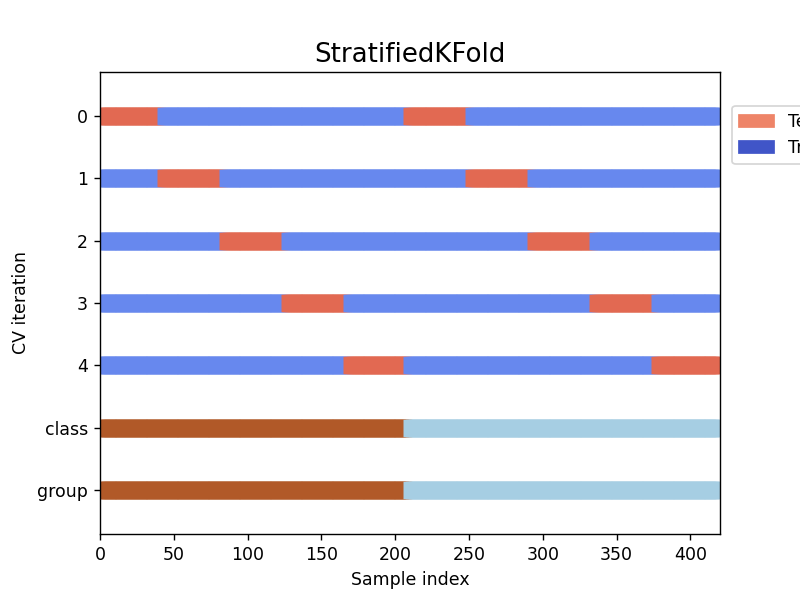

<IPython.core.display.Javascript object>


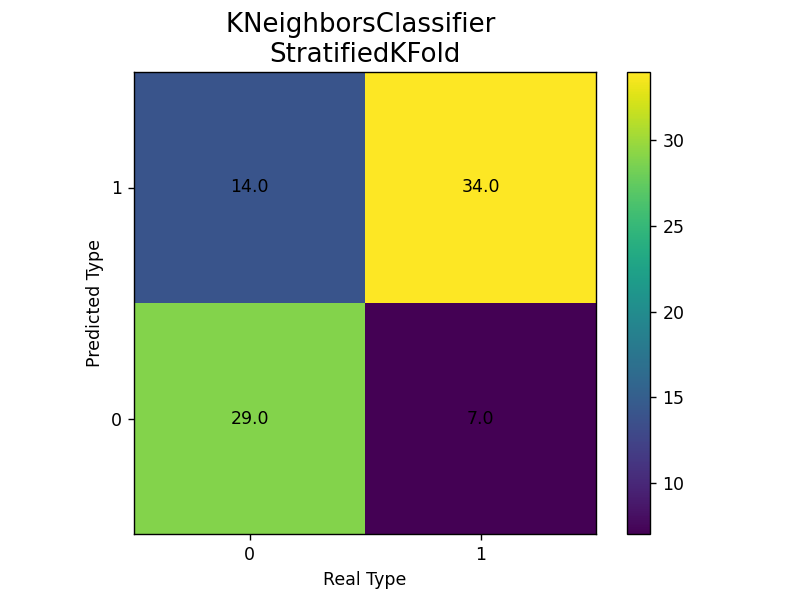

      0     1
0  29.0   7.0
1  14.0  34.0 

Precision: 82.926829%
Recall R: 70.833333%

F-score F1: 76.404494%


<IPython.core.display.Javascript object>


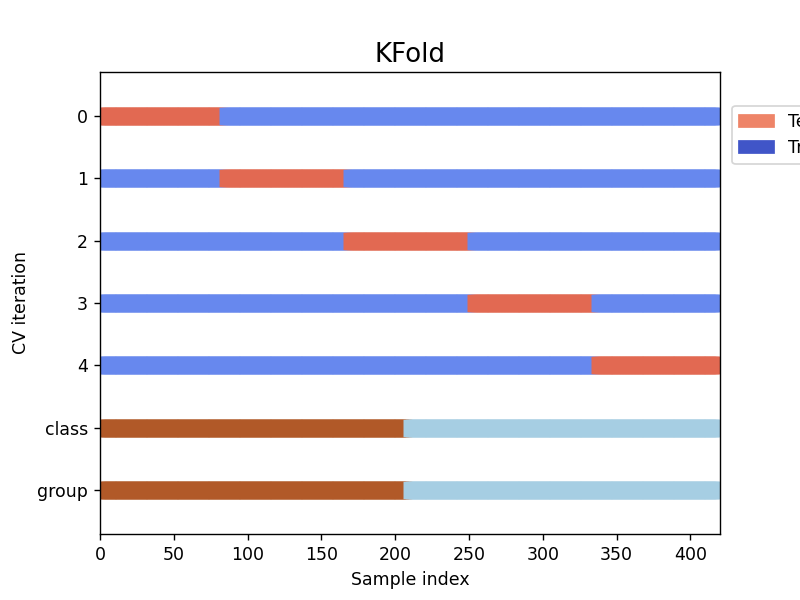

<IPython.core.display.Javascript object>


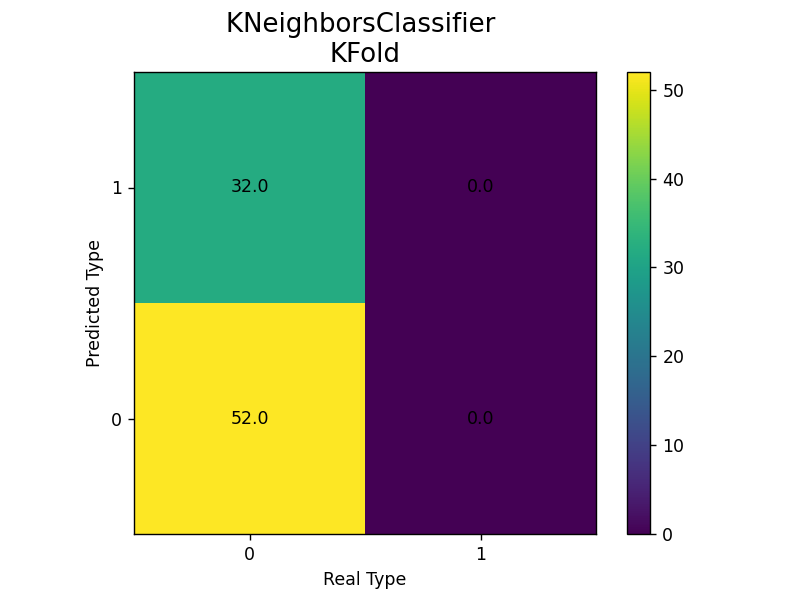

      0    1
0  52.0  0.0
1  32.0  0.0 

P Could not be calculated
F1 Could not be calculated


<IPython.core.display.Javascript object>


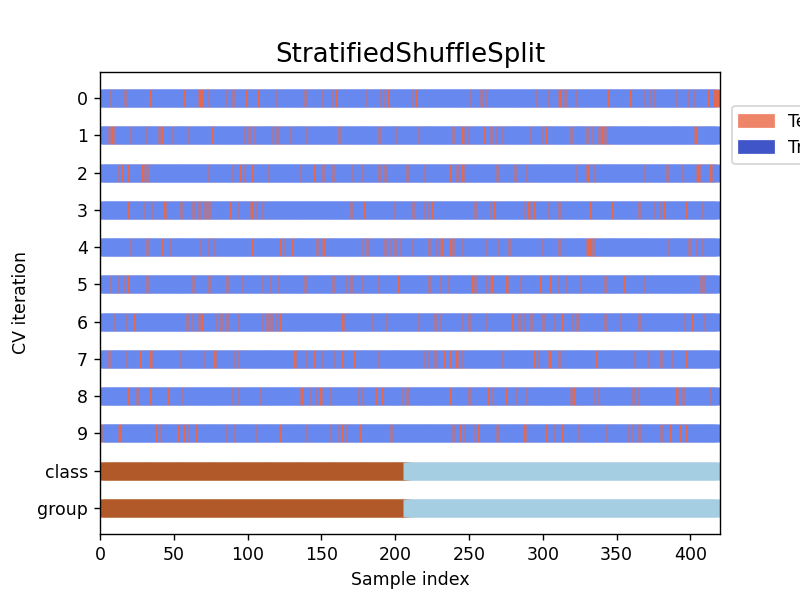

<IPython.core.display.Javascript object>


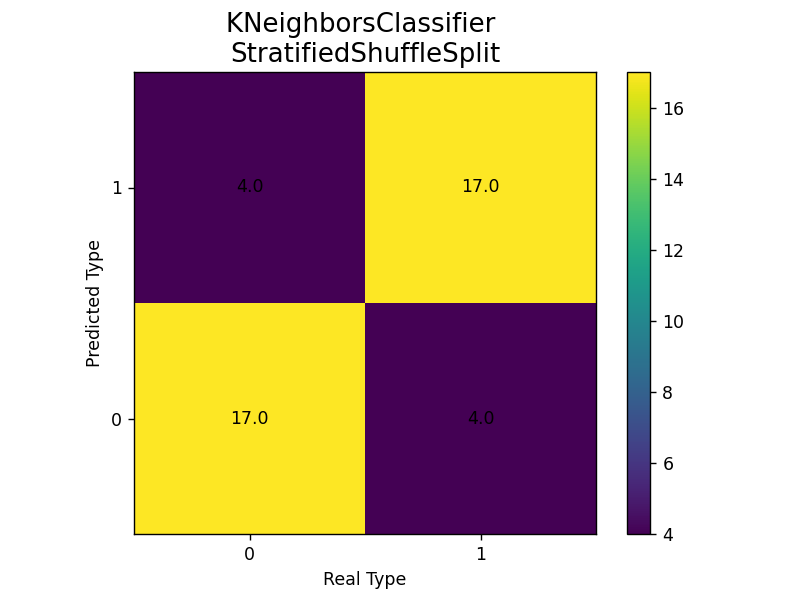

      0     1
0  17.0   4.0
1   4.0  17.0 

Precision: 80.952381%
Recall R: 80.952381%

F-score F1: 80.952381%


<IPython.core.display.Javascript object>


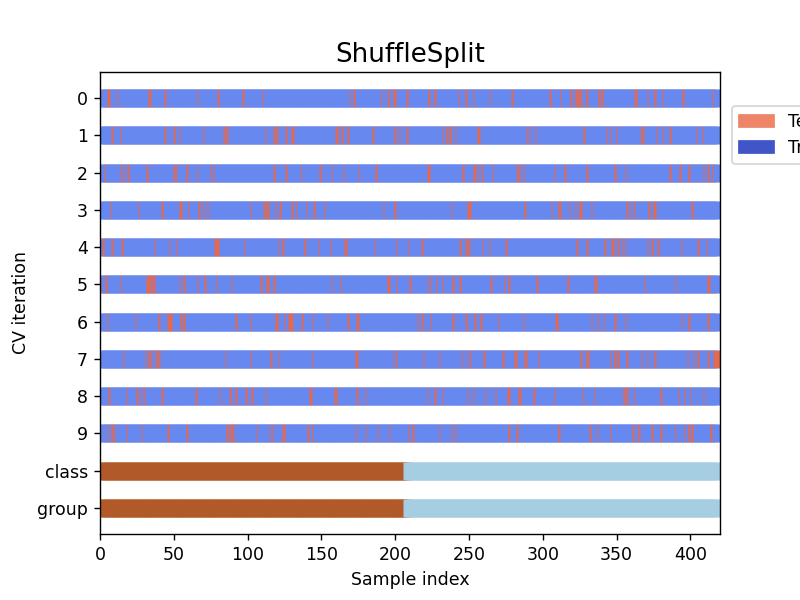

<IPython.core.display.Javascript object>


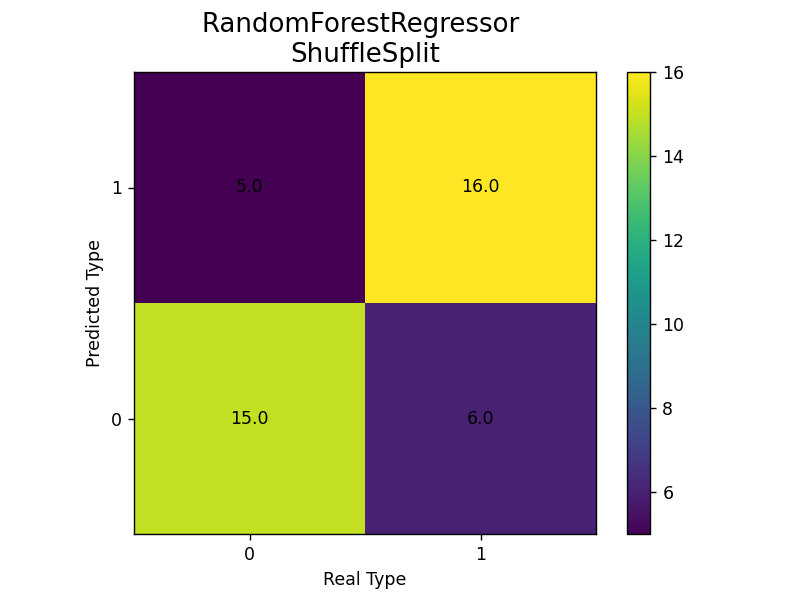

      0     1
0  15.0   6.0
1   5.0  16.0 

Precision: 72.727273%
Recall R: 76.190476%

F-score F1: 74.418605%


<IPython.core.display.Javascript object>


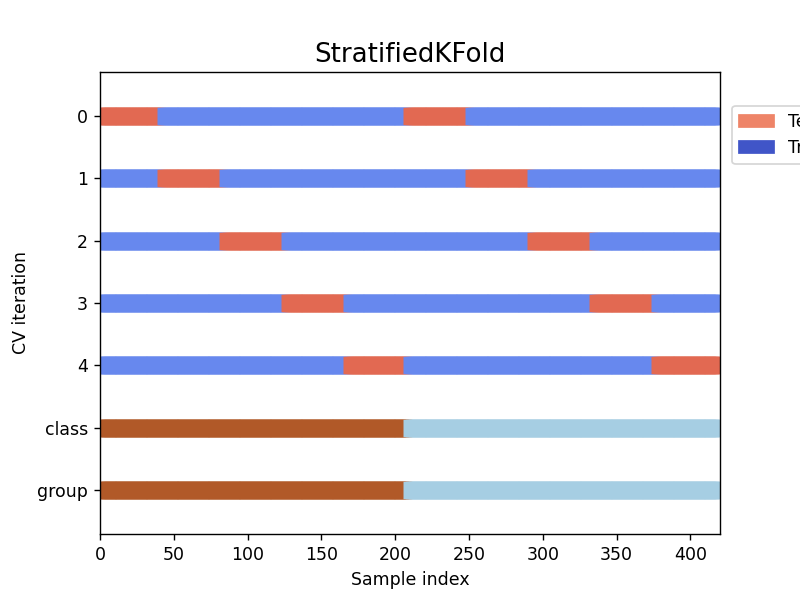

<IPython.core.display.Javascript object>


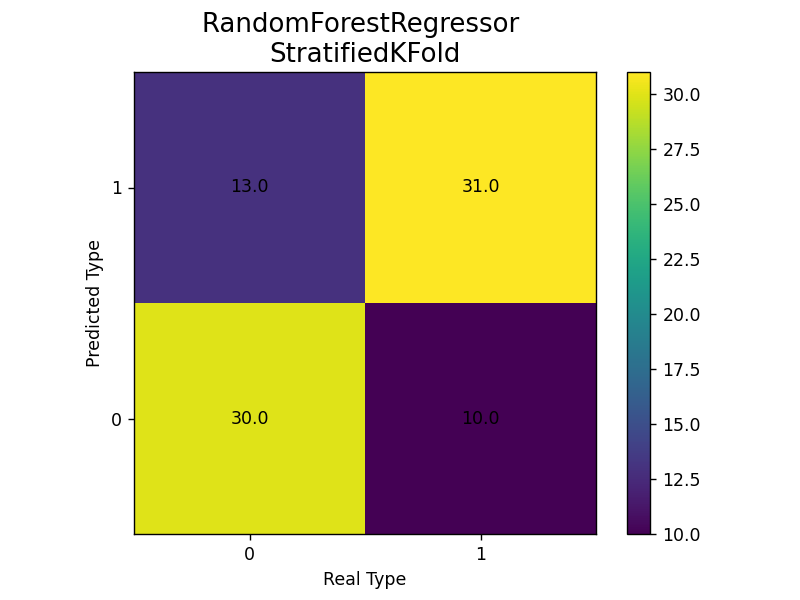

      0     1
0  30.0  10.0
1  13.0  31.0 

Precision: 75.609756%
Recall R: 70.454545%

F-score F1: 72.941176%


<IPython.core.display.Javascript object>


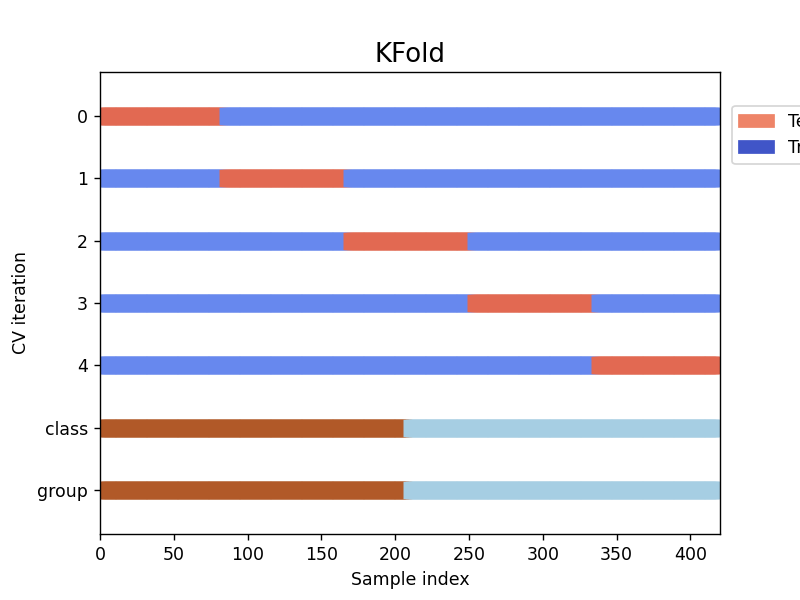

<IPython.core.display.Javascript object>


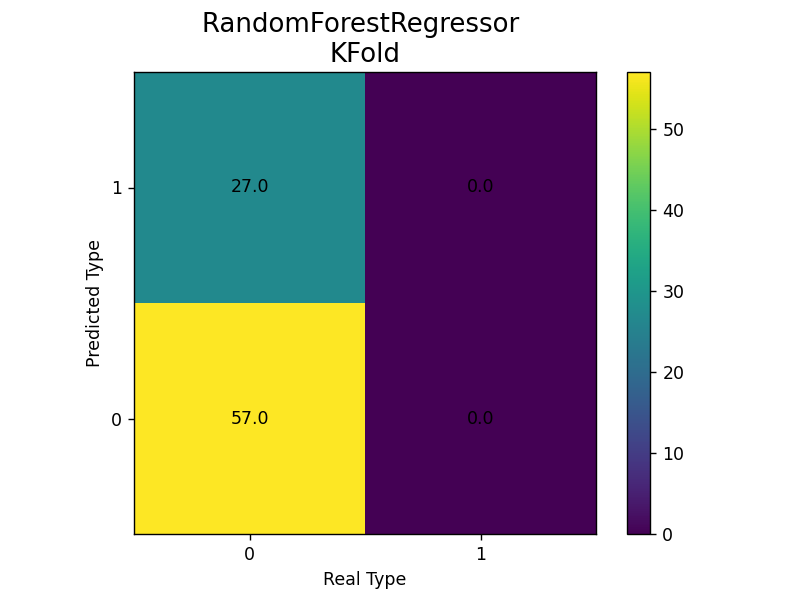

      0    1
0  57.0  0.0
1  27.0  0.0 

P Could not be calculated
F1 Could not be calculated


<IPython.core.display.Javascript object>


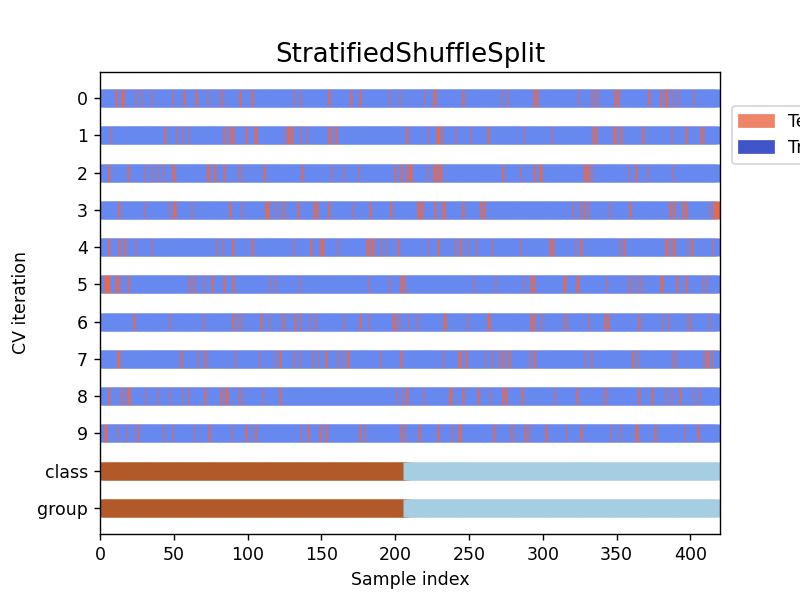

<IPython.core.display.Javascript object>


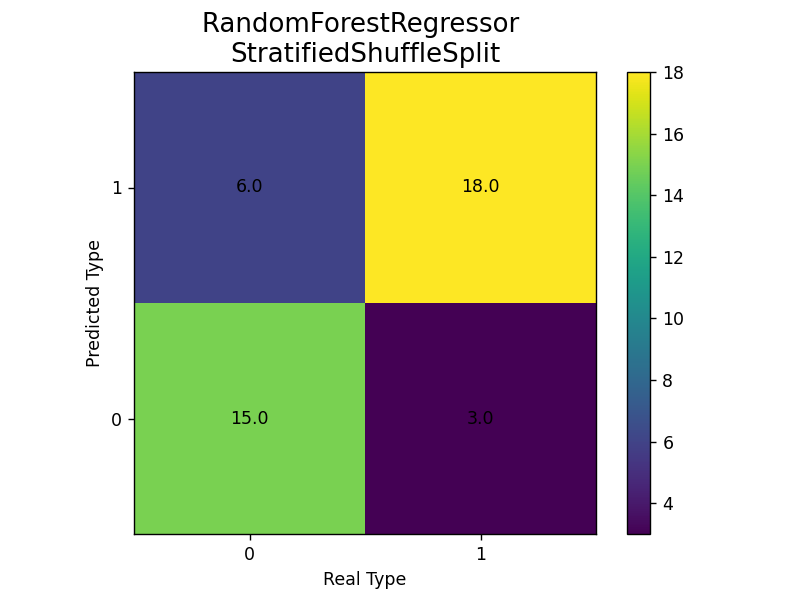

      0     1
0  15.0   3.0
1   6.0  18.0 

Precision: 85.714286%
Recall R: 75.000000%

F-score F1: 80.000000%


In [102]:
#Running different regressors with different splitting techniques and returns the confusion matrix in order
#to determine which ones to use for the data 

reg_list = [LogisticRegression, KNeighborsClassifier, RandomForestRegressor]
cv_list = [ShuffleSplit, StratifiedKFold, KFold, StratifiedShuffleSplit]
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
print(reg_list)

#DEFINE FNAME #MASTER LOOP
fname = 'data/splits/split21.csv'
groups_ = data['stroke'].to_numpy()
for regressor in reg_list: 
    for cv in cv_list:
        
        #print(f'regressor:{str(regressor())}, splitting:{str(cv())}')
        rg = Regressor(regressor, fname, cv)
        
        #cvt = cv()
        #rgt = regressor()
        RFC = RandomForestClassifier()
        a = postplotter(rg.X_test, rg.y_test, rg.y_pred)
        
        fig, ax = plt.subplots()
        plot_cv_indices(rg.cv, rg.X, rg.y, rg.y, ax, rg.cv.get_n_splits() )
        ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))

        #alternatively: use regressor as string from reg_list
        a.confmatrix( '{}'.format(type(rg.regressor).__name__)+' \n{}'.format(type(cv()).__name__)  )
